### Data Loading and Preprocessing

In [1]:
import numpy as np
import random
import os
import tensorflow as tf


# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow

# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms

# Control GPU memory allocation (prevents TensorFlow from using all GPU memory)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism (ensures consistent execution order)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

import scipy.io 
from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report, 
f1_score, precision_score, recall_score, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import signal
from skimage.transform import resize
from sklearn.model_selection import StratifiedKFold
from keras import layers, models, Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, Flatten, MaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model

# Load 2HP CWRU bearing data from .mat files
def import_data():
    """
    Efficiently load CWRU bearing data from .mat files in the specified folder.

    Returns:
        list: A list of NumPy arrays, each corresponding to a different bearing condition.
    """
    folder_path_1 = os.path.join(os.getcwd(), 'CWRU_data', '2HP')

    files = {
        '99.mat': 'X099_DE_time',
        '111.mat': 'X111_DE_time',
        '124.mat': 'X124_DE_time',
        '137.mat': 'X137_DE_time',
        '176.mat': 'X176_DE_time',
        '191.mat': 'X191_DE_time',
        '203.mat': 'X203_DE_time',
        '215.mat': 'X215_DE_time',
        '228.mat': 'X228_DE_time',
        '240.mat': 'X240_DE_time',
    }

    data_2HP = []
    for file_name, key in files.items():
        file_path = os.path.join(folder_path_1, file_name)
        data_2HP.append(scipy.io.loadmat(file_path)[key])

    folder_path_2 =  os.path.join(os.getcwd(), 'CWRU_data', '3HP')
    files = {
        '100.mat': 'X100_DE_time',
        '112.mat': 'X112_DE_time',
        '125.mat': 'X125_DE_time',
        '138.mat': 'X138_DE_time',
        '177.mat': 'X177_DE_time',
        '192.mat': 'X192_DE_time',
        '204.mat': 'X204_DE_time',
        '217.mat': 'X217_DE_time',
        '229.mat': 'X229_DE_time',
        '241.mat': 'X241_DE_time',
    }

    data_3HP = []
    for file_name, key in files.items():
        file_path = os.path.join(folder_path_2, file_name)
        data_3HP.append(scipy.io.loadmat(file_path)[key])

    return data_2HP, data_3HP

data_2HP, data_3HP = import_data()
len(data_2HP), len(data_3HP)

(10, 10)

In [2]:
def sampling(data, interval_length, samples_per_block, ignore_points=0):
    """
    Split the data into blocks of specified length, ignoring the first and last 'ignore_points'.
    Args:
        data (np.ndarray): The input data array to be split.
        interval_length (int): The length of each interval for splitting.
        samples_per_block (int): The number of samples in each block.
        ignore_points (int): The number of points to ignore at the beginning and end of the data.
    Returns:
        np.ndarray: A 2D array where each row is a block of data.
    """ 
    # Adjust data length to ignore the first and last 'ignore_points'
    adjusted_length = len(data) - 2 * ignore_points

    # Adjust the number of blocks
    no_of_blocks = (round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1)
    split_data = np.zeros([no_of_blocks, samples_per_block])

    for i in range(no_of_blocks):
        # Skip the first 'ignore_points' and start sampling from that position
        start_idx = ignore_points + i * interval_length
        split_data[i, :] = data[start_idx:(start_idx + samples_per_block)].T

        # print("Split data shape", split_data[i, :].shape)

    return split_data


def data_preparation(data, interval_length, samples_per_block):
  for count,i in enumerate(data):
    split_data = sampling(i, interval_length, samples_per_block)
    y = np.zeros([len(split_data),10])
    y[:,count] = 1
    y1 = np.zeros([len(split_data),1])
    y1[:,0] = count
    # Stack up and label the data   
    if count==0:
      X = split_data
      y_positional = y
      y_labels = y1
    else:
      X = np.append(X, split_data, axis=0)
      y_positional = np.append(y_positional,y,axis=0)
      y_labels = np.append(y_labels,y1,axis=0)
  return X, y_positional, y_labels

### Overlapping Windows

In [ ]:
interval_length = 320 
samples_per_block = 1600

X_2HP, y_onehot_2HP, y_2HP = data_preparation(data_2HP, interval_length, samples_per_block) 
X_3HP, y_onehot_3HP, y_3HP = data_preparation(data_3HP, interval_length, samples_per_block)

print('Shape of input data (2HP) =', X_2HP.shape)
print('Shape of one hot encoded label(2HP)  =', y_onehot_2HP.shape)
print('Shape of labels (2HP) =', y_2HP.shape)

print('Shape of input data (3HP) =', X_3HP.shape)
print('Shape of one hot encoded label(3HP)  =', y_onehot_3HP.shape)
print('Shape of labels (3HP) =', y_3HP.shape)


Shape of input data (2HP) = (15169, 1600)
Shape of one hot encoded label(2HP)  = (15169, 10)
Shape of labels (2HP) = (15169, 1)
Shape of input data (3HP) = (15171, 1600)
Shape of one hot encoded label(3HP)  = (15171, 10)
Shape of labels (3HP) = (15171, 1)


### Time-Based Train-Test Split

In [4]:
def time_series_stratified_split(X, y, train_ratio = 0.8):
    num_classes = y.shape[1]
    X_train, y_train, X_test, y_test = [], [], [], []

    for cls in range(num_classes):
        cls_indices = np.where(np.argmax(y, axis=1) == cls)[0]
        n_train = int(train_ratio * len(cls_indices))
        train_idx, test_idx = cls_indices[:n_train], cls_indices[n_train:]
        X_train.append(X[train_idx])
        # print("X_train shape:", len(X_train))
        y_train.append(y[train_idx])
        # print("y_train shape:", len(X_train))
        X_test.append(X[test_idx])
        # print("X_train shape:", len(X_train))
        y_test.append(y[test_idx])
        # print("y_test shape:", len(X_train))
        print(f"Class {cls}: Train size = {len(train_idx)}, Test size = {len(test_idx)}")

    return (
        np.concatenate(X_train),
        np.concatenate(y_train),
        np.concatenate(X_test),
        np.concatenate(y_test)
    )

X_train_2HP, y_train_2HP, X_test_2HP, y_test_2HP = time_series_stratified_split(X_2HP, y_onehot_2HP)
X_train_3HP, y_train_3HP, X_test_3HP, y_test_3HP = time_series_stratified_split(X_3HP, y_onehot_3HP)

print("Shape of training data (2HP):", X_train_2HP.shape)
print("Shape of training labels (2HP):", y_train_2HP.shape)
print("Shape of testing data (2HP):", X_test_2HP.shape)
print("Shape of testing labels (2HP):", y_test_2HP.shape)

Class 0: Train size = 1208, Test size = 302
Class 1: Train size = 1209, Test size = 303
Class 2: Train size = 1212, Test size = 303
Class 3: Train size = 1212, Test size = 303
Class 4: Train size = 1215, Test size = 304
Class 5: Train size = 1213, Test size = 304
Class 6: Train size = 1212, Test size = 303
Class 7: Train size = 1224, Test size = 306
Class 8: Train size = 1213, Test size = 304
Class 9: Train size = 1215, Test size = 304
Class 0: Train size = 1209, Test size = 303
Class 1: Train size = 1209, Test size = 303
Class 2: Train size = 1216, Test size = 305
Class 3: Train size = 1215, Test size = 304
Class 4: Train size = 1208, Test size = 302
Class 5: Train size = 1212, Test size = 303
Class 6: Train size = 1216, Test size = 305
Class 7: Train size = 1218, Test size = 305
Class 8: Train size = 1212, Test size = 303
Class 9: Train size = 1218, Test size = 305
Shape of training data (2HP): (12133, 1600)
Shape of training labels (2HP): (12133, 10)
Shape of testing data (2HP): (30

In [5]:
# k-fold cross validation 
k_splits = 5
kfold = StratifiedKFold(n_splits=k_splits, shuffle=False)

# Define window size and number of features
interval_length = 320
samples_per_block = 1600

### CNN-LSTM Model Definition

In [6]:
class CNN_LSTM_Model:
    def __init__(self):
        self.model = self.build_1D_cnn_lstm_model()
    
    def build_1D_cnn_lstm_model(self):
        """
        Build CNN-LSTM model with matched encoder output shapes for element-wise multiplication.
        Returns: Compiled Keras model.
        """
        from keras.layers import Reshape, multiply, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Input
        from keras.models import Model

        input_seq = Input(shape=(1600,))
        X = Reshape((1600, 1))(input_seq)

        # Encoder 1
        ec1_layer1 = Conv1D(filters=50, kernel_size=20, strides=2, padding='valid', activation='relu')(X)
        ec1_layer2 = Conv1D(filters=30, kernel_size=10, strides=2, padding='valid', activation='relu')(ec1_layer1)
        ec1_outputs = MaxPooling1D(pool_size=2, padding='valid')(ec1_layer2)

        # Encoder 2
        ec2_layer1 = Conv1D(filters=50, kernel_size=8, strides=2, padding='valid', activation='relu')(X)
        ec2_layer2 = Conv1D(filters=40, kernel_size=6, strides=2, padding='valid', activation='relu')(ec2_layer1)
        ec2_layer3 = MaxPooling1D(pool_size=2, padding='valid')(ec2_layer2)
        ec2_layer4 = Conv1D(filters=30, kernel_size=4, strides=1, padding='valid', activation='relu')(ec2_layer3)
        ec2_outputs = ec2_layer4

        # Element-wise multiplication
        encoder = multiply([ec1_outputs, ec2_outputs])

        # Decoder
        dc_layer1 = LSTM(60, return_sequences=True)(encoder)
        dc_layer2 = LSTM(60)(dc_layer1)
        dc_layer3 = Dropout(0.5)(dc_layer2)
        dc_layer4 = Dense(10, activation='softmax')(dc_layer3)

        model = Model(input_seq, dc_layer4)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(model.summary())
        return model

In [7]:
# Reshape for CNN-LSTM input (samples_per_block,)
X_train_2HP_CNN_LSTM = X_train_2HP  # Already (n_samples, 1600)
X_test_2HP_CNN_LSTM = X_test_2HP    # Already (n_samples, 1600)
X_train_3HP_CNN_LSTM = X_train_3HP   # Already (n_samples, 1600)
X_test_3HP_CNN_LSTM = X_test_3HP     # Already (n_samples, 1600)

y_train_2HP_CNN_LSTM = y_train_2HP.reshape(y_train_2HP.shape[0], 10)
y_test_2HP_CNN_LSTM = y_test_2HP.reshape(y_test_2HP.shape[0], 10)
y_train_3HP_CNN_LSTM = y_train_3HP.reshape(y_train_3HP.shape[0], 10)
y_test_3HP_CNN_LSTM = y_test_3HP.reshape(y_test_3HP.shape[0], 10)


## Experiment Utility Functions
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
def save_metrics(metrics, filename, fold, model_type, hp):
    """
    Save model metrics to a JSON file.
    """
    metrics_dir = os.path.join("LSTM_results_for_report", "Metrics", model_type, hp)
    os.makedirs(metrics_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filepath = os.path.join(metrics_dir, f"{filename}_fold{fold}_{timestamp}.json")
    with open(filepath, 'w') as f:
        json.dump(metrics, f, indent=4)

def save_best_model(model, fold, model_type, hp, val_acc):
    """
    Save the best model for a given fold.
    """
    models_dir = os.path.join("LSTM_results_for_report", "Models", model_type, hp)
    os.makedirs(models_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filepath = os.path.join(models_dir, f"best_model_fold{fold}_val_acc_{val_acc:.4f}_{timestamp}.h5")
    model.save(filepath)

def plot_confusion_matrix(y_true, y_pred, fold, model_type, hp, class_names):
    """
    Plot and save confusion matrix.
    """
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_type} ({hp}) Fold {fold}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plots_dir = os.path.join("LSTM_results_for_report", "Plots", model_type, hp)
    os.makedirs(plots_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filepath = os.path.join(plots_dir, f"confusion_matrix_fold{fold}_{timestamp}.png")
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def plot_training_curves(history, fold, model_type, hp):
    """
    Plot and save training/validation accuracy and loss curves.
    """
    plots_dir = os.path.join("LSTM_results_for_report", "Plots", model_type, hp)
    os.makedirs(plots_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy Curves - {model_type} ({hp}) Fold {fold}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    filepath = os.path.join(plots_dir, f"accuracy_curve_fold{fold}_{timestamp}.png")
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves - {model_type} ({hp}) Fold {fold}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    filepath = os.path.join(plots_dir, f"loss_curve_fold{fold}_{timestamp}.png")
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [8]:
def run_experiment(X_train, y_train, X_test, y_test, model_class, kfold, model_type, hp, class_names):
    """
    Run k-fold cross-validation experiment and save results.
    """
    fold_metrics = []
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, np.argmax(y_train, axis=1))):
        print(f"\nTraining Fold {fold + 1}/{kfold.n_splits}")
        model = model_class().model
        checkpoint = ModelCheckpoint(
            f"CNN_LSTM_balanced_best_model_fold{fold}.h5",
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        )
        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        )
        history = model.fit(
            X_train[train_idx], y_train[train_idx],
            validation_data=(X_train[val_idx], y_train[val_idx]),
            epochs=50,
            batch_size=32,
            callbacks=[checkpoint, early_stopping],
            verbose=1
        )
        best_model = tf.keras.models.load_model(f"CNN_LSTM_balanced_best_model_fold{fold}.h5")
        train_pred = best_model.predict(X_train[train_idx])
        val_pred = best_model.predict(X_train[val_idx])
        test_pred = best_model.predict(X_test)
        train_acc = tf.keras.metrics.categorical_accuracy(y_train[train_idx], train_pred).numpy().mean()
        val_acc = tf.keras.metrics.categorical_accuracy(y_train[val_idx], val_pred).numpy().mean()
        test_acc = tf.keras.metrics.categorical_accuracy(y_test, test_pred).numpy().mean()
        report = classification_report(
            np.argmax(y_test, axis=1),
            np.argmax(test_pred, axis=1),
            target_names=class_names,
            output_dict=True
        )
        metrics = {
            'fold': fold + 1,
            'train_accuracy': float(train_acc),
            'val_accuracy': float(val_acc),
            'test_accuracy': float(test_acc),
            'classification_report': report
        }
        save_metrics(metrics, "metrics", fold + 1, model_type, hp)
        save_best_model(best_model, fold + 1, model_type, hp, val_acc)
        plot_confusion_matrix(y_test, test_pred, fold + 1, model_type, hp, class_names)
        plot_training_curves(history, fold + 1, model_type, hp)
        fold_metrics.append(metrics)
        os.remove(f"CNN_LSTM_balanced_best_model_fold{fold}.h5")
    avg_metrics = {
        'avg_train_accuracy': float(np.mean([m['train_accuracy'] for m in fold_metrics])),
        'avg_val_accuracy': float(np.mean([m['val_accuracy'] for m in fold_metrics])),
        'avg_test_accuracy': float(np.mean([m['test_accuracy'] for m in fold_metrics]))
    }
    save_metrics(avg_metrics, "average_metrics", 0, model_type, hp)
    return fold_metrics

### Run Experiment

Running 2HP CNN-LSTM Experiment

Training Fold 1/5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1600, 1)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 797, 50)   │        450 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 791, 50)   │      1,050 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 396, 40)   │     12,040 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 391, 30)   │     15,030 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 198, 40)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 195, 30)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 195, 30)   │      4,830 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 195, 30)   │          0 │ max_pooling1d[0]… │
│                     │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 195, 60)   │     21,840 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 60)        │     29,040 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 60)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │        610 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


2025-07-10 15:36:20.590549: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 15:36:20.591872: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.2548 - loss: 1.9244

2025-07-10 15:37:08.510992: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 15:37:08.512242: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 164ms/step - accuracy: 0.2551 - loss: 1.9238 - val_accuracy: 0.3251 - val_loss: 1.6929
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.4162 - loss: 1.4864

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.4163 - loss: 1.4864 - val_accuracy: 0.5488 - val_loss: 1.3930
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4920 - loss: 1.2856

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.4922 - loss: 1.2852 - val_accuracy: 0.6024 - val_loss: 0.8926
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5706 - loss: 1.0295

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.5706 - loss: 1.0295 - val_accuracy: 0.7058 - val_loss: 0.8097
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.6697 - loss: 0.8360 - val_accuracy: 0.6856 - val_loss: 0.6855
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7248 - loss: 0.6391

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.7248 - loss: 0.6391 - val_accuracy: 0.7820 - val_loss: 0.5335
Epoch 7/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7951 - loss: 0.4962

304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 175ms/step - accuracy: 0.7951 - loss: 0.4961 - val_accuracy: 0.8410 - val_loss: 0.3567
Epoch 8/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8258 - loss: 0.4117

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.8258 - loss: 0.4117 - val_accuracy: 0.8640 - val_loss: 0.2697
Epoch 9/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8475 - loss: 0.3437

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.8475 - loss: 0.3437 - val_accuracy: 0.8681 - val_loss: 0.2411
Epoch 10/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8683 - loss: 0.2807

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.8683 - loss: 0.2807 - val_accuracy: 0.8747 - val_loss: 0.2318
Epoch 11/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8777 - loss: 0.2413

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - accuracy: 0.8777 - loss: 0.2413 - val_accuracy: 0.8896 - val_loss: 0.1779
Epoch 12/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.8835 - loss: 0.2294 - val_accuracy: 0.8809 - val_loss: 0.2078
Epoch 13/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 167ms/step - accuracy: 0.8969 - loss: 0.2031 - val_accuracy: 0.8735 - val_loss: 0.2216
Epoch 14/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8891 - loss: 0.2006

304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 166ms/step - accuracy: 0.8891 - loss: 0.2006 - val_accuracy: 0.8937 - val_loss: 0.1619
Epoch 15/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.8969 - loss: 0.1817 - val_accuracy: 0.8904 - val_loss: 0.2177
Epoch 16/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9142 - loss: 0.1705

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - accuracy: 0.9142 - loss: 0.1704 - val_accuracy: 0.9604 - val_loss: 0.1277
Epoch 17/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9489 - loss: 0.1409

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.9489 - loss: 0.1409 - val_accuracy: 0.9687 - val_loss: 0.1096
Epoch 18/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9532 - loss: 0.1330

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.9532 - loss: 0.1330 - val_accuracy: 0.9839 - val_loss: 0.0601
Epoch 19/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - accuracy: 0.9251 - loss: 0.2499 - val_accuracy: 0.9724 - val_loss: 0.1036
Epoch 20/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.9817 - loss: 0.0780 - val_accuracy: 0.9679 - val_loss: 0.1035
Epoch 21/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9752 - loss: 0.0761 - val_accuracy: 0.9786 - val_loss: 0.0668
Epoch 22/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9854 - loss: 0.0559

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9854 - loss: 0.0559 - val_accuracy: 0.9843 - val_loss: 0.0496
Epoch 23/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9906 - loss: 0.0385

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9906 - loss: 0.0385 - val_accuracy: 0.9885 - val_loss: 0.0355
Epoch 24/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9943 - loss: 0.0284

304/304 ━━━━━━━━━━━━━━━━━━━━ 2267s 7s/step - accuracy: 0.9943 - loss: 0.0284 - val_accuracy: 0.9901 - val_loss: 0.0322
Epoch 25/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 166ms/step - accuracy: 0.9932 - loss: 0.0268 - val_accuracy: 0.9650 - val_loss: 0.1429
Epoch 26/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 174ms/step - accuracy: 0.9741 - loss: 0.1194 - val_accuracy: 0.9716 - val_loss: 0.0998
Epoch 27/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.9759 - loss: 0.0975 - val_accuracy: 0.9839 - val_loss: 0.0535
Epoch 28/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9878 - loss: 0.0430 - val_accuracy: 0.9901 - val_loss: 0.0323
Epoch 29/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.9944 - loss: 0.0224 - val_accuracy: 0.9893 - val_loss: 0.0401
Epoch 30/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 163ms/step - accuracy: 0.9711 - loss: 0.1385 - val_accuracy: 0.9674 - val_loss: 0.1212
Epoch 31/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.9773 - loss: 0.0866

2025-07-10 16:41:10.275343: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 16:41:10.276991: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step
 3/76 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step

2025-07-10 16:41:24.338835: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 16:41:24.339178: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step


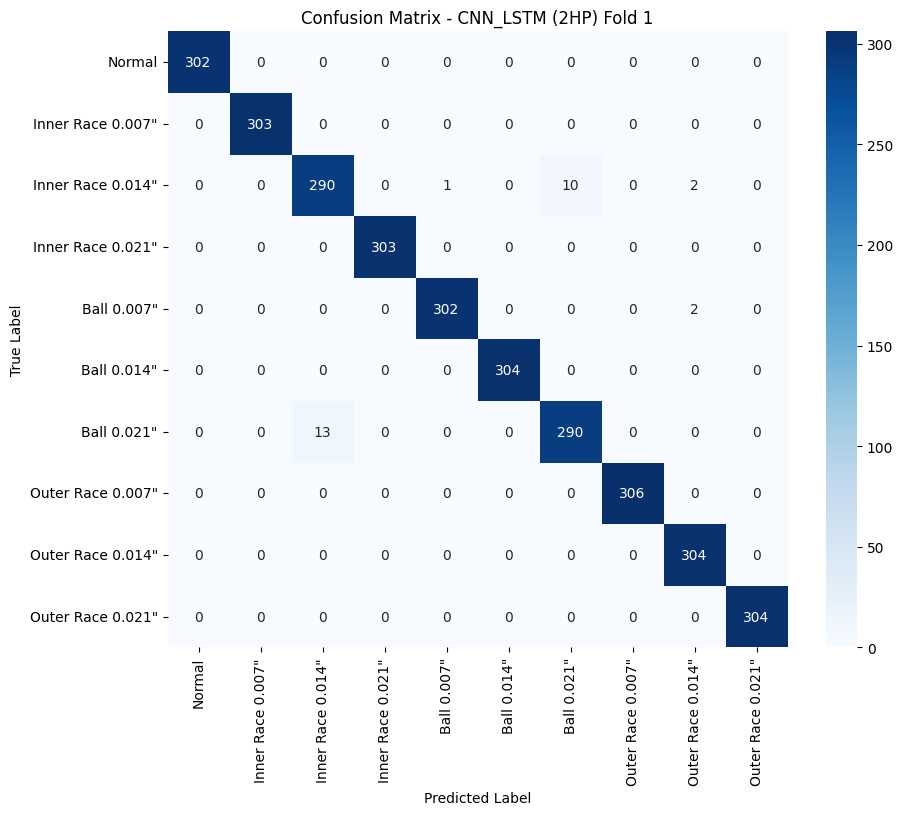

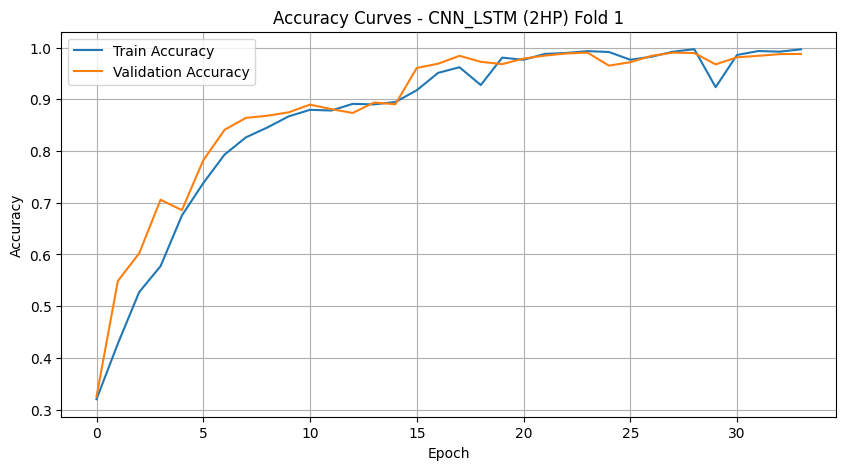

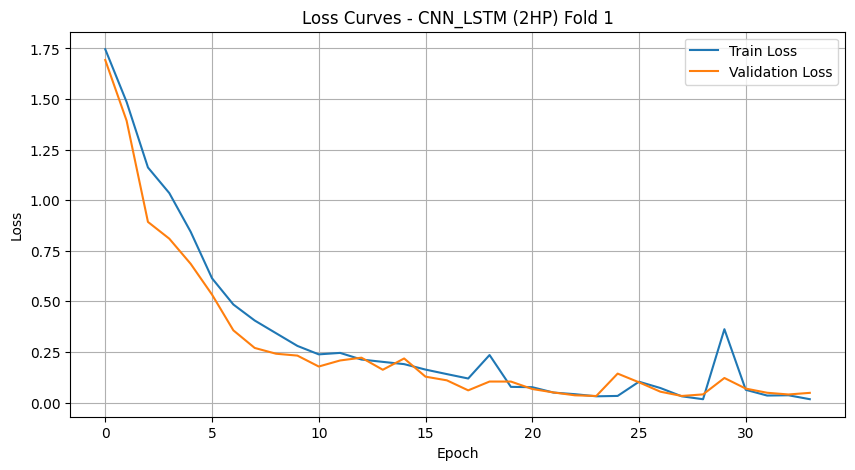


Training Fold 2/5


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 797, 50)   │        450 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 791, 50)   │      1,050 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 396, 40)   │     12,040 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 391, 30)   │     15,030 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 198, 40)   │          0 │ conv1d_8[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 195, 30)   │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 195, 30)   │      4,830 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 195, 30)   │          0 │ max_pooling1d_2[… │
│ (Multiply)          │                   │            │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 60)        │     29,040 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 60)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │        610 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


2025-07-10 16:41:34.167278: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 16:41:34.167681: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.1979 - loss: 2.0565

2025-07-10 16:42:23.681517: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 16:42:23.681952: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - accuracy: 0.1979 - loss: 2.0563 - val_accuracy: 0.3622 - val_loss: 1.6721
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.3892 - loss: 1.5799

304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - accuracy: 0.3894 - loss: 1.5796 - val_accuracy: 0.3894 - val_loss: 1.7298
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5340 - loss: 1.2264

304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 174ms/step - accuracy: 0.5341 - loss: 1.2259 - val_accuracy: 0.6176 - val_loss: 0.8942
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6339 - loss: 0.8962

304/304 ━━━━━━━━━━━━━━━━━━━━ 54s 179ms/step - accuracy: 0.6340 - loss: 0.8961 - val_accuracy: 0.7169 - val_loss: 0.6693
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 55s 182ms/step - accuracy: 0.6473 - loss: 0.8383 - val_accuracy: 0.6448 - val_loss: 0.8583
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7047 - loss: 0.7297

304/304 ━━━━━━━━━━━━━━━━━━━━ 57s 189ms/step - accuracy: 0.7048 - loss: 0.7294 - val_accuracy: 0.7713 - val_loss: 0.4754
Epoch 7/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7708 - loss: 0.5267

304/304 ━━━━━━━━━━━━━━━━━━━━ 65s 213ms/step - accuracy: 0.7708 - loss: 0.5268 - val_accuracy: 0.8496 - val_loss: 0.3515
Epoch 8/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7695 - loss: 0.6395

304/304 ━━━━━━━━━━━━━━━━━━━━ 64s 211ms/step - accuracy: 0.7696 - loss: 0.6390 - val_accuracy: 0.8562 - val_loss: 0.3054
Epoch 9/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7881 - loss: 0.5153

304/304 ━━━━━━━━━━━━━━━━━━━━ 69s 226ms/step - accuracy: 0.7882 - loss: 0.5151 - val_accuracy: 0.8653 - val_loss: 0.2715
Epoch 10/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 71s 234ms/step - accuracy: 0.8573 - loss: 0.3327 - val_accuracy: 0.7384 - val_loss: 0.6855
Epoch 11/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8053 - loss: 0.4812

304/304 ━━━━━━━━━━━━━━━━━━━━ 59s 195ms/step - accuracy: 0.8054 - loss: 0.4809 - val_accuracy: 0.8743 - val_loss: 0.2282
Epoch 12/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8631 - loss: 0.3054

304/304 ━━━━━━━━━━━━━━━━━━━━ 64s 212ms/step - accuracy: 0.8631 - loss: 0.3054 - val_accuracy: 0.8801 - val_loss: 0.2209
Epoch 13/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8643 - loss: 0.2828

304/304 ━━━━━━━━━━━━━━━━━━━━ 61s 200ms/step - accuracy: 0.8642 - loss: 0.2828 - val_accuracy: 0.8826 - val_loss: 0.1976
Epoch 14/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 55s 182ms/step - accuracy: 0.8831 - loss: 0.2461 - val_accuracy: 0.8245 - val_loss: 0.4504
Epoch 15/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8791 - loss: 0.2550

304/304 ━━━━━━━━━━━━━━━━━━━━ 56s 185ms/step - accuracy: 0.8791 - loss: 0.2550 - val_accuracy: 0.8875 - val_loss: 0.1844
Epoch 16/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8846 - loss: 0.2183

304/304 ━━━━━━━━━━━━━━━━━━━━ 62s 205ms/step - accuracy: 0.8846 - loss: 0.2184 - val_accuracy: 0.8912 - val_loss: 0.1684
Epoch 17/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 59s 193ms/step - accuracy: 0.8844 - loss: 0.2157 - val_accuracy: 0.8838 - val_loss: 0.1948
Epoch 18/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8950 - loss: 0.1877

304/304 ━━━━━━━━━━━━━━━━━━━━ 58s 190ms/step - accuracy: 0.8950 - loss: 0.1877 - val_accuracy: 0.8920 - val_loss: 0.1637
Epoch 19/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8959 - loss: 0.1886

304/304 ━━━━━━━━━━━━━━━━━━━━ 54s 179ms/step - accuracy: 0.8959 - loss: 0.1887 - val_accuracy: 0.8953 - val_loss: 0.1635
Epoch 20/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 54s 176ms/step - accuracy: 0.9053 - loss: 0.1658 - val_accuracy: 0.8896 - val_loss: 0.1750
Epoch 21/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 56s 184ms/step - accuracy: 0.9048 - loss: 0.1658 - val_accuracy: 0.8690 - val_loss: 0.3653
Epoch 22/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9131 - loss: 0.2046

304/304 ━━━━━━━━━━━━━━━━━━━━ 58s 190ms/step - accuracy: 0.9131 - loss: 0.2046 - val_accuracy: 0.9378 - val_loss: 0.1403
Epoch 23/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9399 - loss: 0.1426

304/304 ━━━━━━━━━━━━━━━━━━━━ 57s 188ms/step - accuracy: 0.9399 - loss: 0.1426 - val_accuracy: 0.9440 - val_loss: 0.1243
Epoch 24/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 56s 183ms/step - accuracy: 0.9433 - loss: 0.1568 - val_accuracy: 0.9151 - val_loss: 0.2155
Epoch 25/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9407 - loss: 0.1750

304/304 ━━━━━━━━━━━━━━━━━━━━ 60s 198ms/step - accuracy: 0.9407 - loss: 0.1749 - val_accuracy: 0.9674 - val_loss: 0.0858
Epoch 26/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9292 - loss: 0.2335

304/304 ━━━━━━━━━━━━━━━━━━━━ 59s 193ms/step - accuracy: 0.9292 - loss: 0.2333 - val_accuracy: 0.9885 - val_loss: 0.0392
Epoch 27/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 60s 196ms/step - accuracy: 0.9824 - loss: 0.0692 - val_accuracy: 0.9674 - val_loss: 0.0953
Epoch 28/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 68s 223ms/step - accuracy: 0.9790 - loss: 0.0813 - val_accuracy: 0.9819 - val_loss: 0.0593
Epoch 29/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 67s 220ms/step - accuracy: 0.9839 - loss: 0.0590 - val_accuracy: 0.9876 - val_loss: 0.0389
Epoch 30/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 65s 215ms/step - accuracy: 0.9891 - loss: 0.0464 - val_accuracy: 0.9848 - val_loss: 0.0483
Epoch 31/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9828 - loss: 0.0543

304/304 ━━━━━━━━━━━━━━━━━━━━ 66s 217ms/step - accuracy: 0.9828 - loss: 0.0542 - val_accuracy: 0.9922 - val_loss: 0.0220
Epoch 32/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9920 - loss: 0.0305

304/304 ━━━━━━━━━━━━━━━━━━━━ 65s 212ms/step - accuracy: 0.9920 - loss: 0.0305 - val_accuracy: 0.9942 - val_loss: 0.0250
Epoch 33/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 64s 211ms/step - accuracy: 0.9908 - loss: 0.0430 - val_accuracy: 0.9889 - val_loss: 0.0380
Epoch 34/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 62s 204ms/step - accuracy: 0.9892 - loss: 0.0429 - val_accuracy: 0.9897 - val_loss: 0.0340
Epoch 35/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 58s 192ms/step - accuracy: 0.9921 - loss: 0.0296 - val_accuracy: 0.9905 - val_loss: 0.0321
Epoch 36/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 60s 196ms/step - accuracy: 0.9899 - loss: 0.0435 - val_accuracy: 0.9860 - val_loss: 0.0445
Epoch 37/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9916 - loss: 0.0319

304/304 ━━━━━━━━━━━━━━━━━━━━ 64s 211ms/step - accuracy: 0.9916 - loss: 0.0319 - val_accuracy: 0.9959 - val_loss: 0.0158
Epoch 38/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 61s 200ms/step - accuracy: 0.9952 - loss: 0.0235 - val_accuracy: 0.9918 - val_loss: 0.0269
Epoch 39/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 61s 201ms/step - accuracy: 0.9964 - loss: 0.0182 - val_accuracy: 0.9942 - val_loss: 0.0194
Epoch 40/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 61s 200ms/step - accuracy: 0.9958 - loss: 0.0200 - val_accuracy: 0.9852 - val_loss: 0.0482
Epoch 41/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 59s 196ms/step - accuracy: 0.9954 - loss: 0.0210 - val_accuracy: 0.9827 - val_loss: 0.0508
Epoch 42/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 60s 198ms/step - accuracy: 0.9748 - loss: 0.0895 - val_accuracy: 0.9876 - val_loss: 0.0339
Epoch 43/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 64s 211ms/step - accuracy: 0.9912 - loss: 0.0304 - val_accuracy: 0.9909 - val_loss: 0.0400
Epoch 44/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 66s 218ms/step - accuracy: 0.9932 - loss: 0.026

2025-07-10 17:28:52.298996: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 17:28:52.300846: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step
 3/76 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step

2025-07-10 17:29:08.676934: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 17:29:08.677375: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step


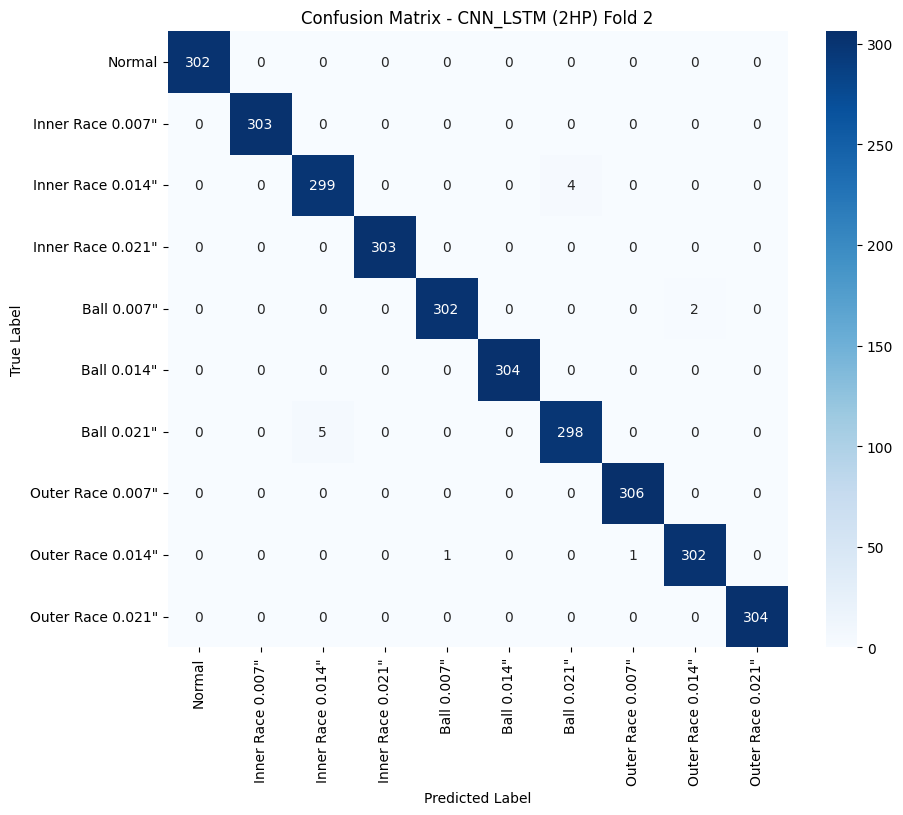

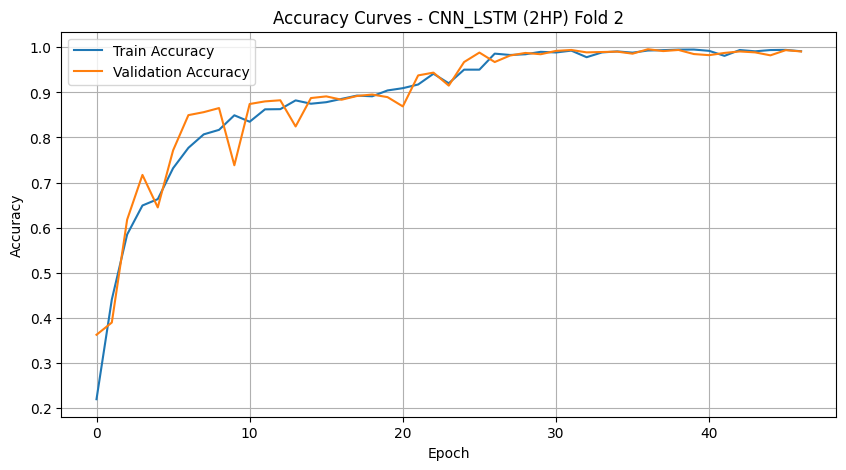

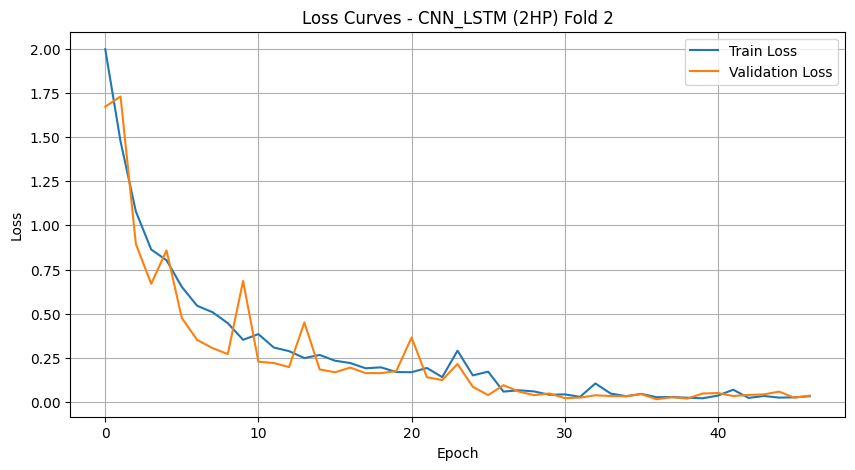


Training Fold 3/5


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 198, 40)   │          0 │ conv1d_13[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 195, 30)   │          0 │ conv1d_11[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 195, 30)   │          0 │ max_pooling1d_4[… │
│ (Multiply)          │                   │            │ conv1d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 60)        │     29,040 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 60)        │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │        610 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


2025-07-10 17:29:19.512290: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 17:29:19.512741: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.2495 - loss: 1.9451

2025-07-10 17:30:15.685363: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 17:30:15.686178: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 60s 190ms/step - accuracy: 0.2498 - loss: 1.9445 - val_accuracy: 0.4409 - val_loss: 1.4466
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5356 - loss: 1.2211

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.5357 - loss: 1.2207 - val_accuracy: 0.5760 - val_loss: 1.0858
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6367 - loss: 0.9137

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.6365 - loss: 0.9140 - val_accuracy: 0.6230 - val_loss: 1.0307
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5509 - loss: 1.1997

304/304 ━━━━━━━━━━━━━━━━━━━━ 714s 2s/step - accuracy: 0.5511 - loss: 1.1989 - val_accuracy: 0.6967 - val_loss: 0.7445
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7381 - loss: 0.6716

304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - accuracy: 0.7381 - loss: 0.6716 - val_accuracy: 0.7944 - val_loss: 0.4489
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8084 - loss: 0.4644

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.8084 - loss: 0.4643 - val_accuracy: 0.8088 - val_loss: 0.4177
Epoch 7/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8280 - loss: 0.4321

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 163ms/step - accuracy: 0.8280 - loss: 0.4321 - val_accuracy: 0.8558 - val_loss: 0.2782
Epoch 8/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8637 - loss: 0.3167

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.8637 - loss: 0.3167 - val_accuracy: 0.8628 - val_loss: 0.2617
Epoch 9/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8306 - loss: 0.3999

304/304 ━━━━━━━━━━━━━━━━━━━━ 54s 177ms/step - accuracy: 0.8306 - loss: 0.4000 - val_accuracy: 0.8661 - val_loss: 0.2518
Epoch 10/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8628 - loss: 0.2835

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.8628 - loss: 0.2835 - val_accuracy: 0.8710 - val_loss: 0.2344
Epoch 11/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8739 - loss: 0.2625

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.8739 - loss: 0.2625 - val_accuracy: 0.8875 - val_loss: 0.1940
Epoch 12/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8916 - loss: 0.2002

304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 172ms/step - accuracy: 0.8916 - loss: 0.2002 - val_accuracy: 0.8879 - val_loss: 0.1772
Epoch 13/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.8807 - loss: 0.2381 - val_accuracy: 0.8871 - val_loss: 0.1784
Epoch 14/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8906 - loss: 0.1978

304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 167ms/step - accuracy: 0.8906 - loss: 0.1978 - val_accuracy: 0.8937 - val_loss: 0.1642
Epoch 15/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8921 - loss: 0.1858

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.8921 - loss: 0.1858 - val_accuracy: 0.8958 - val_loss: 0.1576
Epoch 16/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.8946 - loss: 0.1697 - val_accuracy: 0.8929 - val_loss: 0.1652
Epoch 17/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.8971 - loss: 0.1643 - val_accuracy: 0.8941 - val_loss: 0.1690
Epoch 18/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9050 - loss: 0.1598

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.9050 - loss: 0.1599 - val_accuracy: 0.8986 - val_loss: 0.1726
Epoch 19/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9133 - loss: 0.1960

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.9133 - loss: 0.1959 - val_accuracy: 0.9172 - val_loss: 0.1550
Epoch 20/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9310 - loss: 0.1560 - val_accuracy: 0.9168 - val_loss: 0.1500
Epoch 21/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9424 - loss: 0.1333 - val_accuracy: 0.8780 - val_loss: 0.5292
Epoch 22/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9354 - loss: 0.1843

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9354 - loss: 0.1842 - val_accuracy: 0.9588 - val_loss: 0.1090
Epoch 23/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9436 - loss: 0.1391

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9436 - loss: 0.1391 - val_accuracy: 0.9691 - val_loss: 0.0905
Epoch 24/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9755 - loss: 0.0766 - val_accuracy: 0.9633 - val_loss: 0.0976
Epoch 25/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9834 - loss: 0.0606

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9834 - loss: 0.0606 - val_accuracy: 0.9819 - val_loss: 0.0543
Epoch 26/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9873 - loss: 0.0505 - val_accuracy: 0.9571 - val_loss: 0.1122
Epoch 27/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9704 - loss: 0.1275 - val_accuracy: 0.9749 - val_loss: 0.0856
Epoch 28/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9865 - loss: 0.0490

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9865 - loss: 0.0490 - val_accuracy: 0.9864 - val_loss: 0.0462
Epoch 29/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9897 - loss: 0.0417 - val_accuracy: 0.9806 - val_loss: 0.0624
Epoch 30/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9901 - loss: 0.0357 - val_accuracy: 0.9864 - val_loss: 0.0478
Epoch 31/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9896 - loss: 0.0370 - val_accuracy: 0.9823 - val_loss: 0.0555
Epoch 32/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.9967 - loss: 0.0139 - val_accuracy: 0.9856 - val_loss: 0.0503
Epoch 33/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9948 - loss: 0.0193

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.9948 - loss: 0.0194 - val_accuracy: 0.9885 - val_loss: 0.0385
Epoch 34/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.9921 - loss: 0.0300 - val_accuracy: 0.9868 - val_loss: 0.0593
Epoch 35/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9973 - loss: 0.0111

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9973 - loss: 0.0111 - val_accuracy: 0.9893 - val_loss: 0.0431
Epoch 36/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9791 - loss: 0.0753 - val_accuracy: 0.9864 - val_loss: 0.0395
Epoch 37/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9941 - loss: 0.0272 - val_accuracy: 0.9843 - val_loss: 0.0437
Epoch 38/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9803 - loss: 0.0843

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9804 - loss: 0.0842 - val_accuracy: 0.9901 - val_loss: 0.0306
Epoch 39/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9905 - loss: 0.0403 - val_accuracy: 0.9827 - val_loss: 0.0525
Epoch 40/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9972 - loss: 0.0164 - val_accuracy: 0.9852 - val_loss: 0.0459
Epoch 41/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9989 - loss: 0.0065 - val_accuracy: 0.9885 - val_loss: 0.0353
Epoch 42/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9967 - loss: 0.0148 - val_accuracy: 0.9901 - val_loss: 0.0356
Epoch 43/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9892 - loss: 0.0462 - val_accuracy: 0.9835 - val_loss: 0.0628
Epoch 44/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9955 - loss: 0.0204 - val_accuracy: 0.9881 - val_loss: 0.0476
Epoch 45/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9985 - loss: 0.008

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9968 - loss: 0.0144 - val_accuracy: 0.9905 - val_loss: 0.0298
Epoch 47/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9984 - loss: 0.0065 - val_accuracy: 0.9901 - val_loss: 0.0310
Epoch 48/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9994 - loss: 0.0037

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9994 - loss: 0.0037 - val_accuracy: 0.9922 - val_loss: 0.0296
Epoch 49/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9922 - val_loss: 0.0406
Epoch 50/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.9989 - loss: 0.0066 - val_accuracy: 0.9922 - val_loss: 0.0315


2025-07-10 18:20:17.499707: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 18:20:17.500925: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step
 3/76 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step

2025-07-10 18:20:30.840102: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 18:20:30.840463: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step


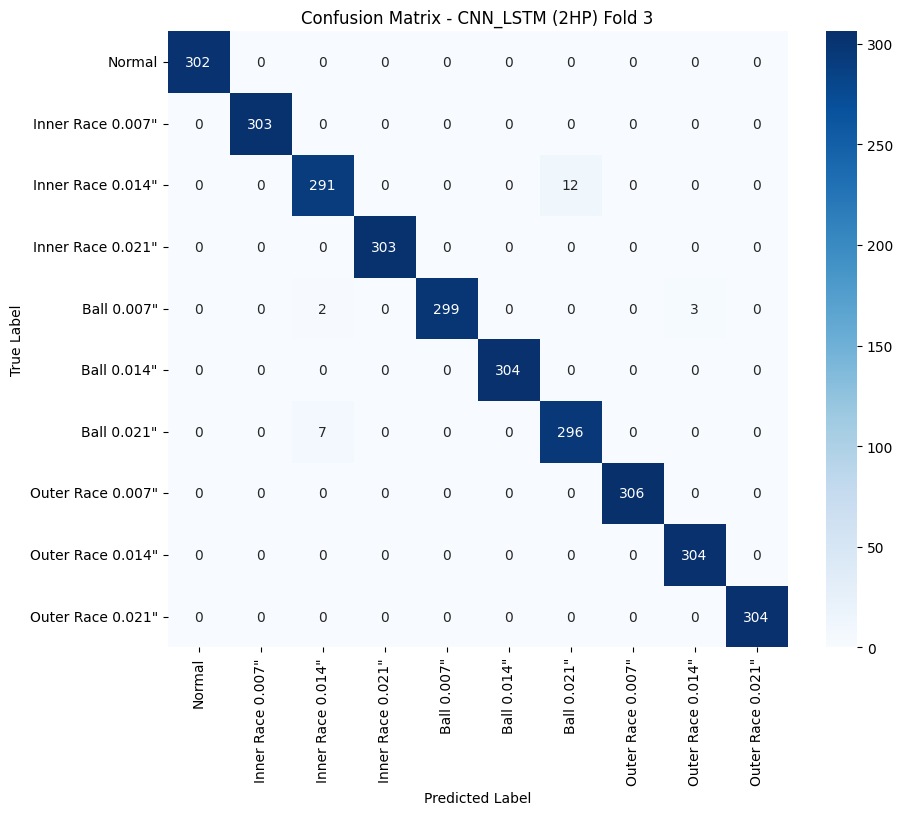

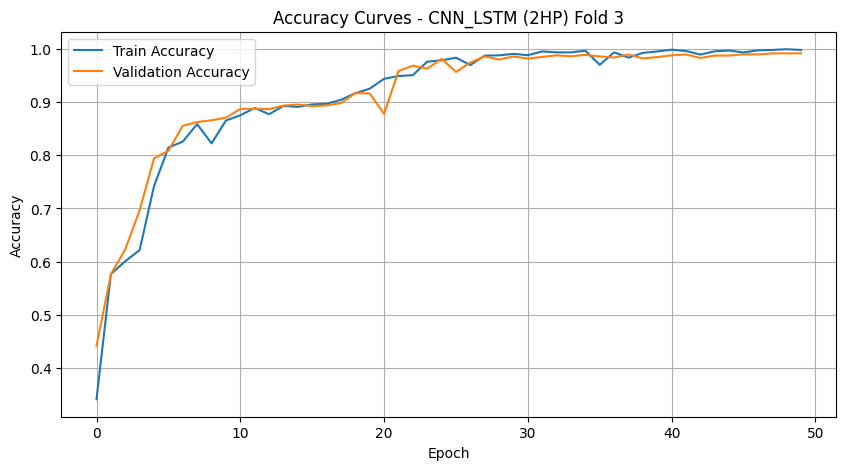

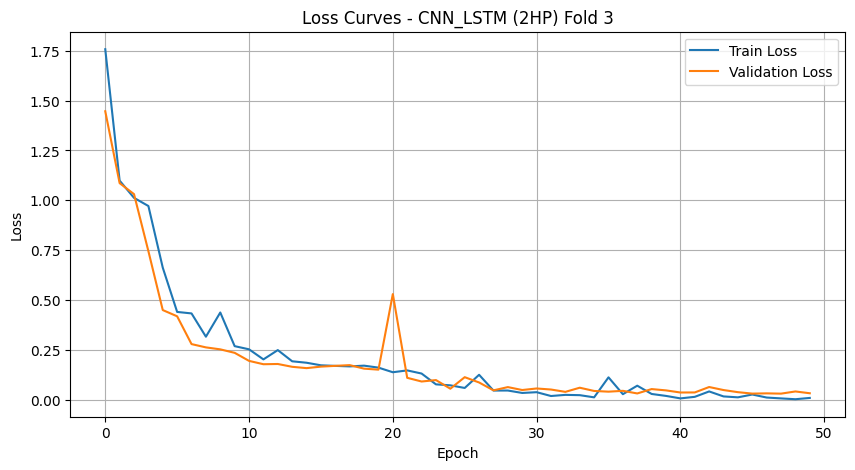


Training Fold 4/5


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 198, 40)   │          0 │ conv1d_18[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 195, 30)   │          0 │ conv1d_16[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 195, 30)   │          0 │ max_pooling1d_6[… │
│ (Multiply)          │                   │            │ conv1d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 60)        │     29,040 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 60)        │          0 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │        610 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


2025-07-10 18:20:41.150666: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 18:20:41.151068: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.2244 - loss: 2.0119

2025-07-10 18:21:26.810875: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 18:21:26.811232: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - accuracy: 0.2246 - loss: 2.0115 - val_accuracy: 0.4621 - val_loss: 1.4230
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.4914 - loss: 1.3188

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.4915 - loss: 1.3184 - val_accuracy: 0.6195 - val_loss: 0.8552
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6139 - loss: 0.9228

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.6140 - loss: 0.9226 - val_accuracy: 0.6855 - val_loss: 0.7253
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6806 - loss: 0.7731

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.6806 - loss: 0.7731 - val_accuracy: 0.7209 - val_loss: 0.6446
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7136 - loss: 0.6745

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.7136 - loss: 0.6745 - val_accuracy: 0.7667 - val_loss: 0.5312
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7276 - loss: 0.6326

304/304 ━━━━━━━━━━━━━━━━━━━━ 1457s 5s/step - accuracy: 0.7277 - loss: 0.6325 - val_accuracy: 0.7836 - val_loss: 0.4883
Epoch 7/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7836 - loss: 0.5219

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.7837 - loss: 0.5218 - val_accuracy: 0.8281 - val_loss: 0.3743
Epoch 8/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.7637 - loss: 0.6325 - val_accuracy: 0.8145 - val_loss: 0.4254
Epoch 9/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8175 - loss: 0.4049

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.8175 - loss: 0.4048 - val_accuracy: 0.8430 - val_loss: 0.3412
Epoch 10/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8280 - loss: 0.3945

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.8280 - loss: 0.3943 - val_accuracy: 0.8644 - val_loss: 0.2494
Epoch 11/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8682 - loss: 0.2597

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.8682 - loss: 0.2597 - val_accuracy: 0.8726 - val_loss: 0.2409
Epoch 12/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8772 - loss: 0.2423

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.8772 - loss: 0.2423 - val_accuracy: 0.8949 - val_loss: 0.1754
Epoch 13/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.8575 - loss: 0.3405 - val_accuracy: 0.8829 - val_loss: 0.2179
Epoch 14/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.8859 - loss: 0.2192 - val_accuracy: 0.8904 - val_loss: 0.1826
Epoch 15/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.8928 - loss: 0.1826 - val_accuracy: 0.8920 - val_loss: 0.1745
Epoch 16/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8881 - loss: 0.1928

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.8881 - loss: 0.1928 - val_accuracy: 0.8974 - val_loss: 0.1732
Epoch 17/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9057 - loss: 0.1676

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9057 - loss: 0.1676 - val_accuracy: 0.9200 - val_loss: 0.1644
Epoch 18/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9115 - loss: 0.1705

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.9116 - loss: 0.1705 - val_accuracy: 0.9810 - val_loss: 0.1010
Epoch 19/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.9215 - loss: 0.1625 - val_accuracy: 0.8957 - val_loss: 0.1691
Epoch 20/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.8627 - loss: 0.2867 - val_accuracy: 0.9159 - val_loss: 0.1645
Epoch 21/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.9081 - loss: 0.1823 - val_accuracy: 0.9761 - val_loss: 0.1006
Epoch 22/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.9508 - loss: 0.1393 - val_accuracy: 0.9699 - val_loss: 0.0926
Epoch 23/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.9706 - loss: 0.0950 - val_accuracy: 0.9732 - val_loss: 0.0989
Epoch 24/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9704 - loss: 0.1064

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9704 - loss: 0.1064 - val_accuracy: 0.9872 - val_loss: 0.0469
Epoch 25/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.9855 - loss: 0.0543 - val_accuracy: 0.9872 - val_loss: 0.0405
Epoch 26/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9771 - loss: 0.0771

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.9771 - loss: 0.0771 - val_accuracy: 0.9918 - val_loss: 0.0319
Epoch 27/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9855 - loss: 0.0490

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.9855 - loss: 0.0490 - val_accuracy: 0.9946 - val_loss: 0.0255
Epoch 28/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.9829 - loss: 0.0598 - val_accuracy: 0.9885 - val_loss: 0.0399
Epoch 29/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.9888 - loss: 0.0478 - val_accuracy: 0.9802 - val_loss: 0.0750
Epoch 30/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - accuracy: 0.9881 - loss: 0.0428 - val_accuracy: 0.9703 - val_loss: 0.1155
Epoch 31/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.9811 - loss: 0.0739 - val_accuracy: 0.9847 - val_loss: 0.0383
Epoch 32/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.9931 - loss: 0.0295 - val_accuracy: 0.9893 - val_loss: 0.0324
Epoch 33/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.9750 - loss: 0.1033 - val_accuracy: 0.9905 - val_loss: 0.0278
Epoch 34/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.9899 - loss: 0.036

2025-07-10 19:13:52.047679: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 19:13:52.048606: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step
 3/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step

2025-07-10 19:14:05.688142: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 19:14:05.688496: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


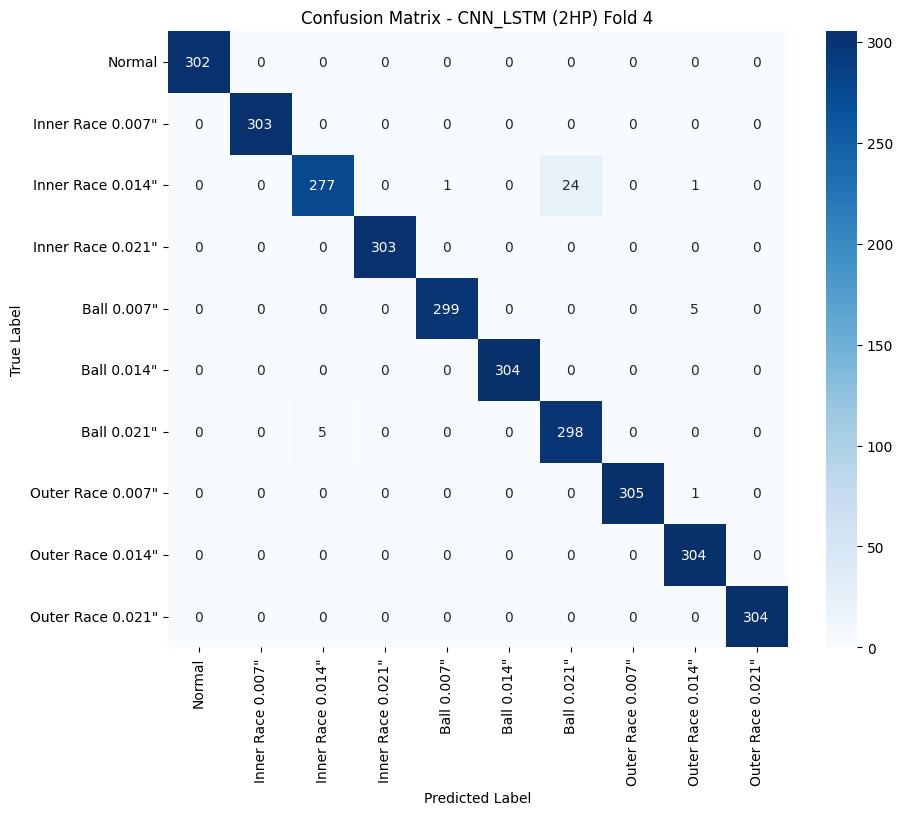

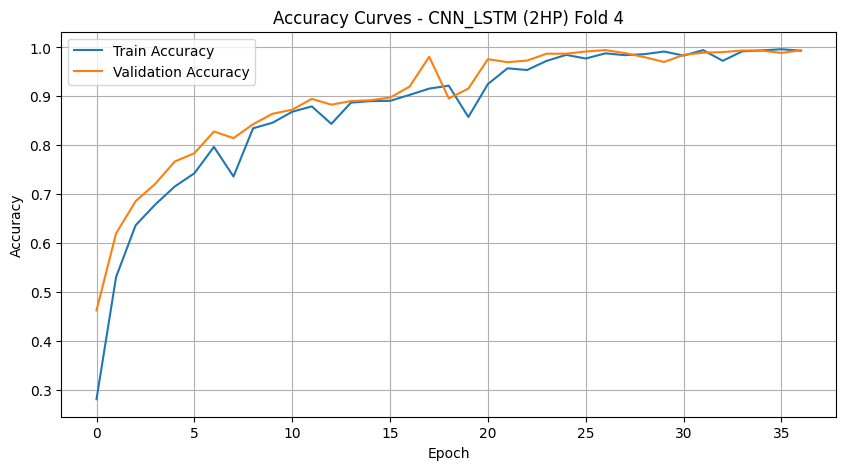

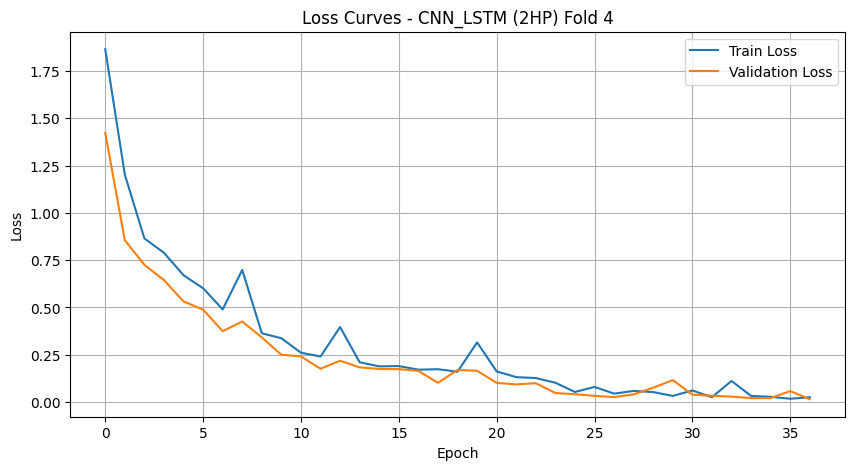


Training Fold 5/5


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 198, 40)   │          0 │ conv1d_23[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 195, 30)   │          0 │ conv1d_21[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 195, 30)   │          0 │ max_pooling1d_8[… │
│ (Multiply)          │                   │            │ conv1d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 60)        │     29,040 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 60)        │          0 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 10)        │        610 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


2025-07-10 19:14:15.101451: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 19:14:15.102060: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.2296 - loss: 1.9617

2025-07-10 19:15:01.764506: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 19:15:01.764877: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 160ms/step - accuracy: 0.2299 - loss: 1.9611 - val_accuracy: 0.5231 - val_loss: 1.3134
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.4805 - loss: 1.4359 - val_accuracy: 0.5181 - val_loss: 1.3967
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5353 - loss: 1.2429

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.5353 - loss: 1.2425 - val_accuracy: 0.6694 - val_loss: 0.8550
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.4986 - loss: 1.2906 - val_accuracy: 0.5973 - val_loss: 1.1318
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.5466 - loss: 1.0915 - val_accuracy: 0.6348 - val_loss: 0.9143
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.6232 - loss: 0.9777 - val_accuracy: 0.6294 - val_loss: 0.8929
Epoch 7/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.5119 - loss: 1.3699 - val_accuracy: 0.5845 - val_loss: 1.0246
Epoch 8/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.4402 - loss: 1.6108 - val_accuracy: 0.6187 - val_loss: 0.9665
Epoch 9/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6485 - loss: 0.8576

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.6486 - loss: 0.8574 - val_accuracy: 0.7436 - val_loss: 0.6257
Epoch 10/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6975 - loss: 0.7880

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.6975 - loss: 0.7877 - val_accuracy: 0.7836 - val_loss: 0.4876
Epoch 11/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7662 - loss: 0.5484

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.7662 - loss: 0.5483 - val_accuracy: 0.8520 - val_loss: 0.3380
Epoch 12/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.8193 - loss: 0.4442 - val_accuracy: 0.8421 - val_loss: 0.3804
Epoch 13/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.8212 - loss: 0.4098 - val_accuracy: 0.8487 - val_loss: 0.3086
Epoch 14/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8188 - loss: 0.4717

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.8188 - loss: 0.4717 - val_accuracy: 0.8578 - val_loss: 0.3261
Epoch 15/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8326 - loss: 0.4027

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.8326 - loss: 0.4027 - val_accuracy: 0.8908 - val_loss: 0.2001
Epoch 16/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.8849 - loss: 0.2496 - val_accuracy: 0.8887 - val_loss: 0.1989
Epoch 17/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.8907 - loss: 0.2118 - val_accuracy: 0.8895 - val_loss: 0.1852
Epoch 18/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8921 - loss: 0.2153

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.8921 - loss: 0.2153 - val_accuracy: 0.9114 - val_loss: 0.1801
Epoch 19/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8918 - loss: 0.2412

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.8918 - loss: 0.2412 - val_accuracy: 0.9188 - val_loss: 0.1892
Epoch 20/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9156 - loss: 0.2254

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.9156 - loss: 0.2254 - val_accuracy: 0.9406 - val_loss: 0.1406
Epoch 21/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9574 - loss: 0.1344

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.9574 - loss: 0.1344 - val_accuracy: 0.9555 - val_loss: 0.1251
Epoch 22/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9734 - loss: 0.0992

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.9734 - loss: 0.0992 - val_accuracy: 0.9732 - val_loss: 0.0845
Epoch 23/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.9734 - loss: 0.0990 - val_accuracy: 0.9670 - val_loss: 0.0952
Epoch 24/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.9755 - loss: 0.0901 - val_accuracy: 0.9699 - val_loss: 0.1040
Epoch 25/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - accuracy: 0.9462 - loss: 0.2298 - val_accuracy: 0.9551 - val_loss: 0.1073
Epoch 26/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9719 - loss: 0.0941

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - accuracy: 0.9719 - loss: 0.0940 - val_accuracy: 0.9835 - val_loss: 0.0548
Epoch 27/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9877 - loss: 0.0560

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.9876 - loss: 0.0561 - val_accuracy: 0.9868 - val_loss: 0.0456
Epoch 28/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9855 - loss: 0.0567

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.9855 - loss: 0.0567 - val_accuracy: 0.9880 - val_loss: 0.0403
Epoch 29/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.9829 - loss: 0.0695 - val_accuracy: 0.9864 - val_loss: 0.0485
Epoch 30/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - accuracy: 0.9918 - loss: 0.0365 - val_accuracy: 0.9827 - val_loss: 0.0516
Epoch 31/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.9933 - loss: 0.0304 - val_accuracy: 0.9749 - val_loss: 0.0734
Epoch 32/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.9933 - loss: 0.0284 - val_accuracy: 0.9831 - val_loss: 0.0576
Epoch 33/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9818 - loss: 0.0699

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.9818 - loss: 0.0698 - val_accuracy: 0.9889 - val_loss: 0.0459
Epoch 34/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.9952 - loss: 0.0216 - val_accuracy: 0.9769 - val_loss: 0.0859
Epoch 35/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - accuracy: 0.9938 - loss: 0.0227 - val_accuracy: 0.9860 - val_loss: 0.0567
Epoch 36/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.9933 - loss: 0.0235 - val_accuracy: 0.9876 - val_loss: 0.0499
Epoch 37/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.9947 - loss: 0.0221 - val_accuracy: 0.9880 - val_loss: 0.0506
Epoch 38/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - accuracy: 0.9865 - loss: 0.0547 - val_accuracy: 0.9876 - val_loss: 0.0547
Epoch 39/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.9905 - loss: 0.0416 - val_accuracy: 0.9864 - val_loss: 0.0434
Epoch 40/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.9938 - loss: 0.029

2025-07-10 19:48:34.938011: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 19:48:34.939060: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step
 3/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step

2025-07-10 19:48:48.853050: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 19:48:48.853389: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


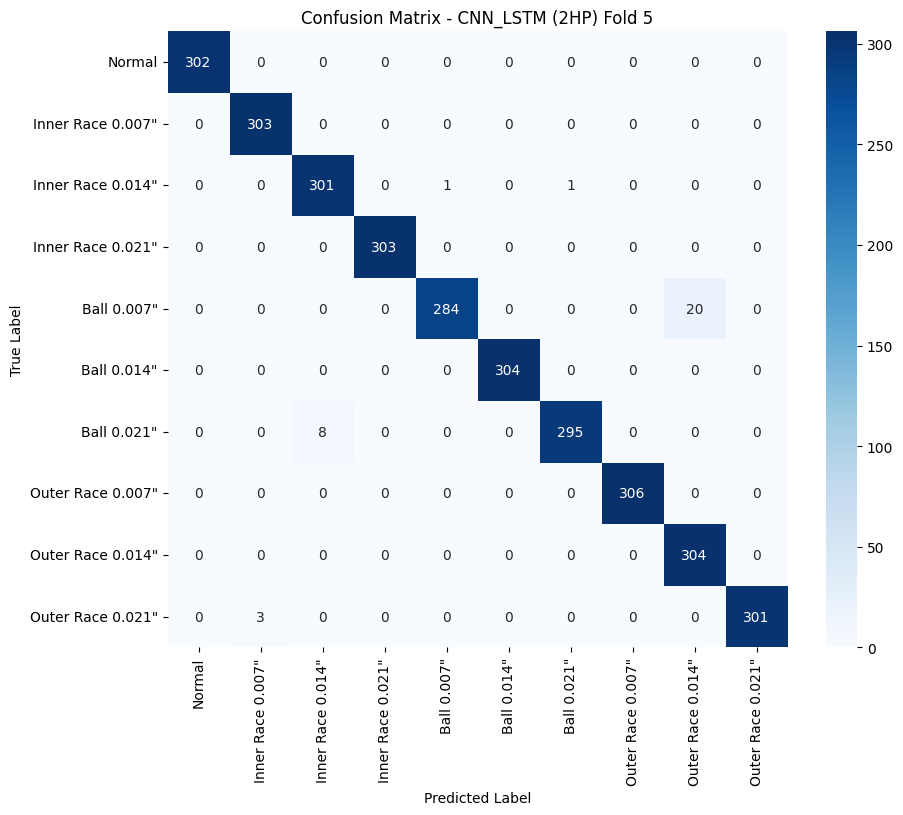

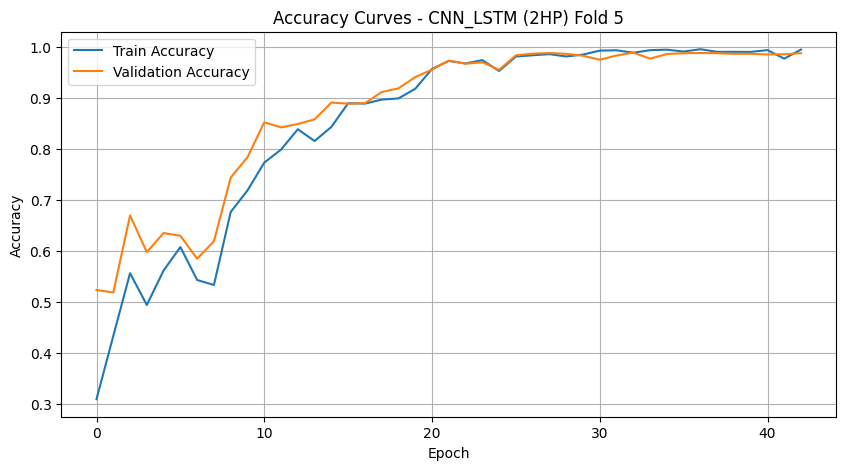

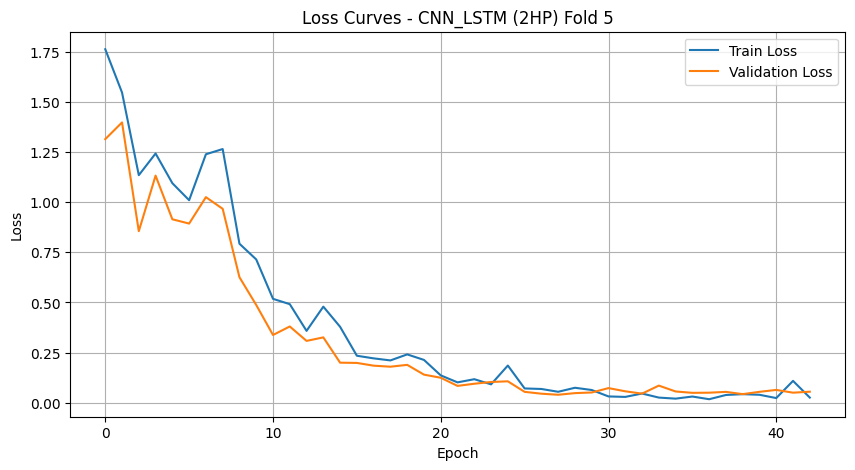


Running 3HP CNN-LSTM Experiment

Training Fold 1/5


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 198, 40)   │          0 │ conv1d_28[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 195, 30)   │          0 │ conv1d_26[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_5          │ (None, 195, 30)   │          0 │ max_pooling1d_10… │
│ (Multiply)          │                   │            │ conv1d_29[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 195, 60)   │     21,840 │ multiply_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 60)        │     29,040 │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 60)        │          0 │ lstm_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10)        │        610 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


2025-07-10 19:48:59.995379: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 19:48:59.995943: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.2436 - loss: 1.9471

2025-07-10 19:49:45.594909: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 19:49:45.595872: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - accuracy: 0.2438 - loss: 1.9464 - val_accuracy: 0.5600 - val_loss: 1.2035
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4862 - loss: 1.3761

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.4863 - loss: 1.3757 - val_accuracy: 0.5950 - val_loss: 0.9437
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6125 - loss: 0.9787

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.6125 - loss: 0.9784 - val_accuracy: 0.6135 - val_loss: 0.8719
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.6537 - loss: 0.8477 - val_accuracy: 0.4392 - val_loss: 1.2307
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6675 - loss: 0.8562

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.6677 - loss: 0.8557 - val_accuracy: 0.7260 - val_loss: 0.6822
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7424 - loss: 0.6585

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.7421 - loss: 0.6592 - val_accuracy: 0.7437 - val_loss: 0.7163
Epoch 7/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7412 - loss: 0.6606

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.7412 - loss: 0.6606 - val_accuracy: 0.7693 - val_loss: 0.6015
Epoch 8/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8012 - loss: 0.4620

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.8012 - loss: 0.4619 - val_accuracy: 0.7771 - val_loss: 0.5599
Epoch 9/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.8384 - loss: 0.3939 - val_accuracy: 0.7598 - val_loss: 0.6338
Epoch 10/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8464 - loss: 0.3397

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.8464 - loss: 0.3399 - val_accuracy: 0.7936 - val_loss: 0.5589
Epoch 11/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8398 - loss: 0.3829

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.8398 - loss: 0.3828 - val_accuracy: 0.8241 - val_loss: 0.4892
Epoch 12/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.8715 - loss: 0.2618 - val_accuracy: 0.8171 - val_loss: 0.4982
Epoch 13/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8887 - loss: 0.2310

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.8886 - loss: 0.2311 - val_accuracy: 0.8331 - val_loss: 0.4750
Epoch 14/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8544 - loss: 0.2880

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.8545 - loss: 0.2879 - val_accuracy: 0.8430 - val_loss: 0.4697
Epoch 15/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8934 - loss: 0.1967

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.8934 - loss: 0.1968 - val_accuracy: 0.8484 - val_loss: 0.4807
Epoch 16/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8765 - loss: 0.2434

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.8766 - loss: 0.2433 - val_accuracy: 0.8525 - val_loss: 0.4542
Epoch 17/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8991 - loss: 0.1834

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.8991 - loss: 0.1834 - val_accuracy: 0.8570 - val_loss: 0.4498
Epoch 18/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9050 - loss: 0.1657

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.9050 - loss: 0.1657 - val_accuracy: 0.8986 - val_loss: 0.4663
Epoch 19/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9122 - loss: 0.1887 - val_accuracy: 0.5439 - val_loss: 1.3022
Epoch 20/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.6884 - loss: 0.9328 - val_accuracy: 0.7219 - val_loss: 0.9634
Epoch 21/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.7985 - loss: 0.5011 - val_accuracy: 0.8269 - val_loss: 0.4972
Epoch 22/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.8541 - loss: 0.3064 - val_accuracy: 0.8475 - val_loss: 0.4731
Epoch 23/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.8863 - loss: 0.2396 - val_accuracy: 0.8261 - val_loss: 0.5528
Epoch 24/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.8882 - loss: 0.2083 - val_accuracy: 0.8529 - val_loss: 0.5096
Epoch 25/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.8998 - loss: 0.202

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.9078 - loss: 0.1714 - val_accuracy: 0.9007 - val_loss: 0.4863
Epoch 29/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9120 - loss: 0.1676

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9119 - loss: 0.1676 - val_accuracy: 0.9205 - val_loss: 0.4731
Epoch 30/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9342 - loss: 0.1468

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.9341 - loss: 0.1469 - val_accuracy: 0.9242 - val_loss: 0.4972
Epoch 31/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.9335 - loss: 0.1629 - val_accuracy: 0.8364 - val_loss: 0.6862
Epoch 32/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9249 - loss: 0.1887 - val_accuracy: 0.9023 - val_loss: 0.5523
Epoch 33/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9152 - loss: 0.2300 - val_accuracy: 0.9085 - val_loss: 0.5392
Epoch 34/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9382 - loss: 0.1328 - val_accuracy: 0.9225 - val_loss: 0.4999
Epoch 35/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9667 - loss: 0.0960 - val_accuracy: 0.8892 - val_loss: 0.5684
Epoch 36/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9742 - loss: 0.0791 - val_accuracy: 0.9172 - val_loss: 0.5791
Epoch 37/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9312 - loss: 0.2055

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.9312 - loss: 0.2055 - val_accuracy: 0.9398 - val_loss: 0.4910
Epoch 38/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9558 - loss: 0.1259 - val_accuracy: 0.9361 - val_loss: 0.5305
Epoch 39/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9841 - loss: 0.0546

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9841 - loss: 0.0545 - val_accuracy: 0.9464 - val_loss: 0.5261
Epoch 40/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9887 - loss: 0.0404

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9887 - loss: 0.0404 - val_accuracy: 0.9489 - val_loss: 0.5466
Epoch 41/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9855 - loss: 0.0457 - val_accuracy: 0.9440 - val_loss: 0.4802
Epoch 42/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9845 - loss: 0.0516 - val_accuracy: 0.9489 - val_loss: 0.5248
Epoch 43/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9892 - loss: 0.0429 - val_accuracy: 0.9427 - val_loss: 0.5349
Epoch 44/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9829 - loss: 0.0509 - val_accuracy: 0.9044 - val_loss: 0.5972
Epoch 45/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9824 - loss: 0.0538 - val_accuracy: 0.9481 - val_loss: 0.5274
Epoch 46/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9879 - loss: 0.0465 - val_accuracy: 0.9295 - val_loss: 0.5097
Epoch 47/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9842 - loss: 0.052

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9883 - loss: 0.0362 - val_accuracy: 0.9506 - val_loss: 0.5719
Epoch 50/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9950 - loss: 0.0197

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9950 - loss: 0.0197 - val_accuracy: 0.9514 - val_loss: 0.5106


2025-07-10 20:27:55.553279: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 20:27:55.554212: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step
 3/76 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step

2025-07-10 20:28:08.615462: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 20:28:08.615817: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step


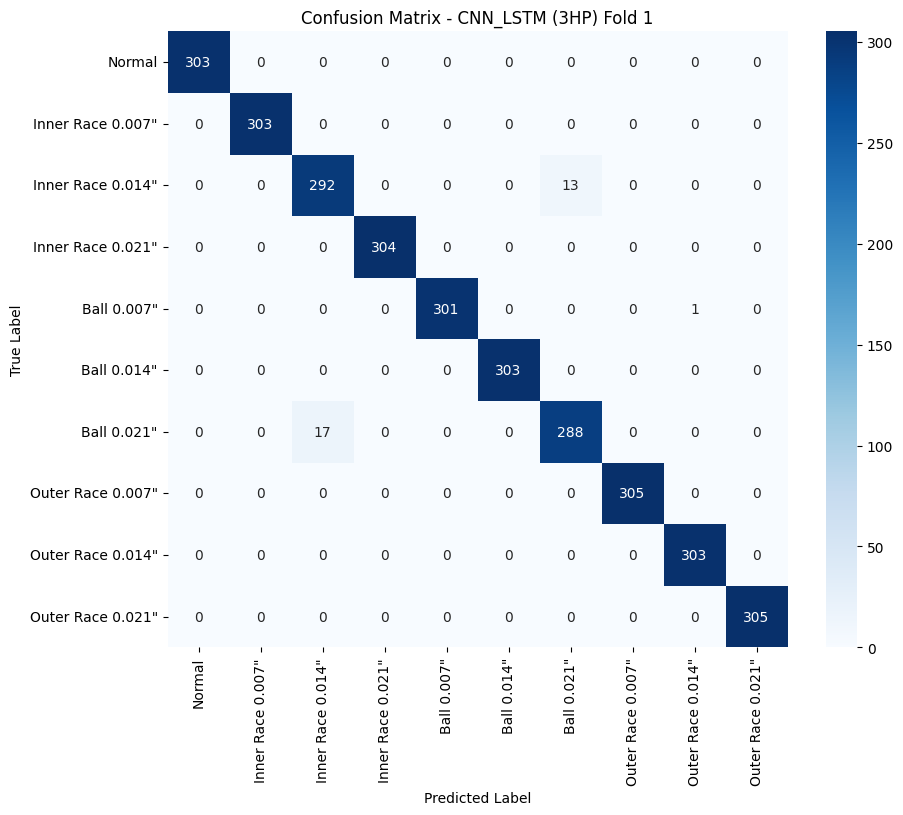

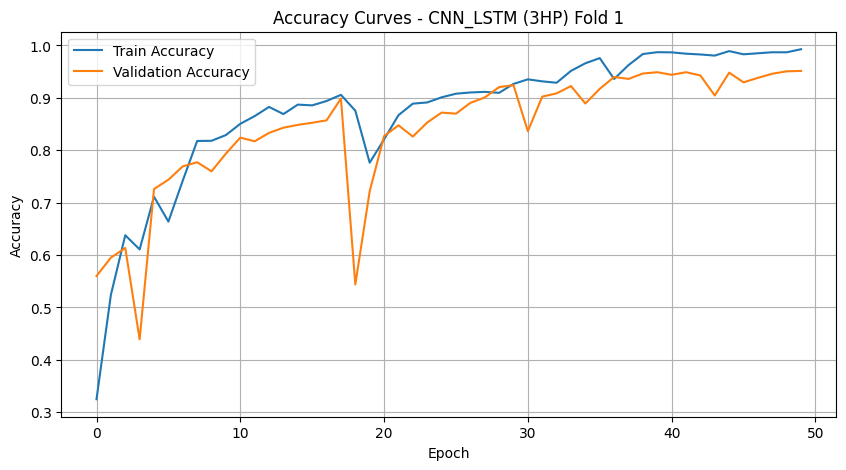

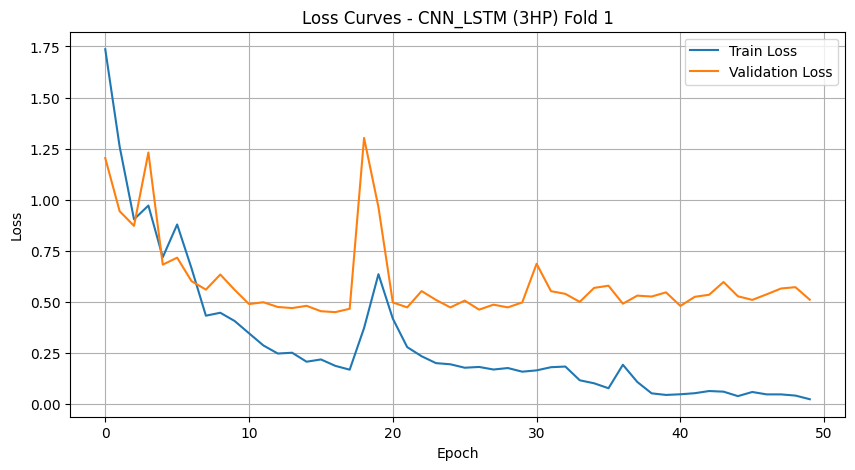


Training Fold 2/5


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 198, 40)   │          0 │ conv1d_33[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 195, 30)   │          0 │ conv1d_31[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_6          │ (None, 195, 30)   │          0 │ max_pooling1d_12… │
│ (Multiply)          │                   │            │ conv1d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 195, 60)   │     21,840 │ multiply_6[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 60)        │     29,040 │ lstm_12[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 60)        │          0 │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10)        │        610 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


2025-07-10 20:28:17.807331: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 20:28:17.807735: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.1859 - loss: 2.0724

2025-07-10 20:29:03.602421: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 20:29:03.602941: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - accuracy: 0.1861 - loss: 2.0722 - val_accuracy: 0.3086 - val_loss: 1.7856
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.2676 - loss: 1.9456

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.2678 - loss: 1.9451 - val_accuracy: 0.3956 - val_loss: 1.5059
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4337 - loss: 1.4416

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.4338 - loss: 1.4414 - val_accuracy: 0.5332 - val_loss: 1.2143
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5404 - loss: 1.1506

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.5406 - loss: 1.1503 - val_accuracy: 0.5851 - val_loss: 0.9299
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6450 - loss: 0.8778

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.6451 - loss: 0.8775 - val_accuracy: 0.6020 - val_loss: 1.0894
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6502 - loss: 0.9288

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.6502 - loss: 0.9287 - val_accuracy: 0.7351 - val_loss: 0.6227
Epoch 7/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7217 - loss: 0.6598

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.7217 - loss: 0.6597 - val_accuracy: 0.7717 - val_loss: 0.4865
Epoch 8/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.7620 - loss: 0.5457 - val_accuracy: 0.7487 - val_loss: 0.5505
Epoch 9/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.7552 - loss: 0.5752 - val_accuracy: 0.7618 - val_loss: 0.4796
Epoch 10/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7955 - loss: 0.4890

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.7955 - loss: 0.4889 - val_accuracy: 0.8216 - val_loss: 0.3635
Epoch 11/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8448 - loss: 0.3737

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.8448 - loss: 0.3737 - val_accuracy: 0.8661 - val_loss: 0.2501
Epoch 12/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.8228 - loss: 0.4067 - val_accuracy: 0.8603 - val_loss: 0.2728
Epoch 13/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8635 - loss: 0.2984

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.8634 - loss: 0.2985 - val_accuracy: 0.8793 - val_loss: 0.2414
Epoch 14/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.8560 - loss: 0.3103 - val_accuracy: 0.8014 - val_loss: 0.4422
Epoch 15/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8302 - loss: 0.3684

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.8302 - loss: 0.3683 - val_accuracy: 0.8797 - val_loss: 0.2101
Epoch 16/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8618 - loss: 0.3086

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.8618 - loss: 0.3085 - val_accuracy: 0.8817 - val_loss: 0.1974
Epoch 17/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.8843 - loss: 0.2425 - val_accuracy: 0.8677 - val_loss: 0.2503
Epoch 18/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8903 - loss: 0.2278

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.8903 - loss: 0.2277 - val_accuracy: 0.9468 - val_loss: 0.1452
Epoch 19/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9237 - loss: 0.1830

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.9237 - loss: 0.1831 - val_accuracy: 0.9559 - val_loss: 0.1543
Epoch 20/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9353 - loss: 0.1826 - val_accuracy: 0.9106 - val_loss: 0.1769
Epoch 21/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9288 - loss: 0.1801 - val_accuracy: 0.9510 - val_loss: 0.1275
Epoch 22/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.9509 - loss: 0.1498 - val_accuracy: 0.7878 - val_loss: 0.6938
Epoch 23/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9135 - loss: 0.2347 - val_accuracy: 0.8937 - val_loss: 0.1615
Epoch 24/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9077 - loss: 0.1848 - val_accuracy: 0.9543 - val_loss: 0.1093
Epoch 25/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - accuracy: 0.9592 - loss: 0.1271 - val_accuracy: 0.9275 - val_loss: 0.1912
Epoch 26/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9632 - loss: 0.1152

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.9632 - loss: 0.1151 - val_accuracy: 0.9769 - val_loss: 0.0833
Epoch 27/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - accuracy: 0.9744 - loss: 0.0903 - val_accuracy: 0.9588 - val_loss: 0.1231
Epoch 28/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9677 - loss: 0.1055

304/304 ━━━━━━━━━━━━━━━━━━━━ 106s 349ms/step - accuracy: 0.9677 - loss: 0.1055 - val_accuracy: 0.9778 - val_loss: 0.0666
Epoch 29/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9776 - loss: 0.0797

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9776 - loss: 0.0797 - val_accuracy: 0.9794 - val_loss: 0.0601
Epoch 30/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 174ms/step - accuracy: 0.9837 - loss: 0.0624 - val_accuracy: 0.9728 - val_loss: 0.0698
Epoch 31/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9765 - loss: 0.0830

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.9765 - loss: 0.0830 - val_accuracy: 0.9872 - val_loss: 0.0432
Epoch 32/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.9831 - loss: 0.0627 - val_accuracy: 0.9827 - val_loss: 0.0496
Epoch 33/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9742 - loss: 0.0846 - val_accuracy: 0.9695 - val_loss: 0.0795
Epoch 34/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9849 - loss: 0.0486 - val_accuracy: 0.9778 - val_loss: 0.0610
Epoch 35/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 175ms/step - accuracy: 0.9777 - loss: 0.0734 - val_accuracy: 0.9757 - val_loss: 0.0697
Epoch 36/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 54s 176ms/step - accuracy: 0.9822 - loss: 0.0505 - val_accuracy: 0.9802 - val_loss: 0.0529
Epoch 37/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9760 - loss: 0.0947 - val_accuracy: 0.9852 - val_loss: 0.0417
Epoch 38/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 55s 178ms/step - accuracy: 0.9877 - loss: 0.045

2025-07-10 21:08:19.265977: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 21:08:19.268035: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step
 2/76 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step

2025-07-10 21:08:34.010252: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 21:08:34.010631: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step


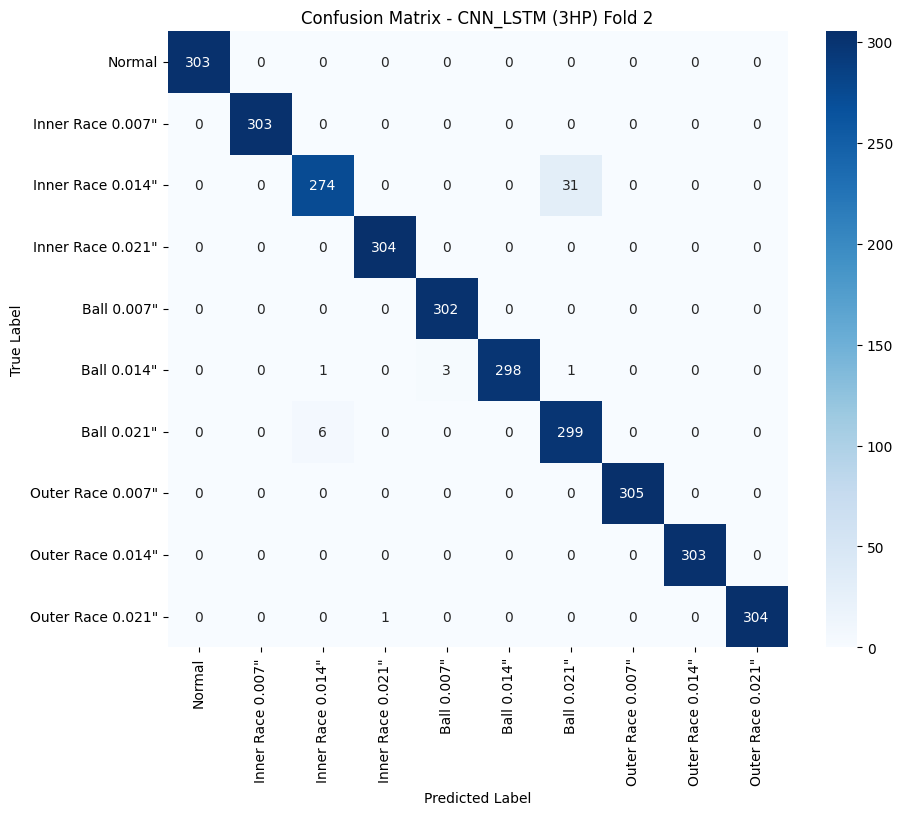

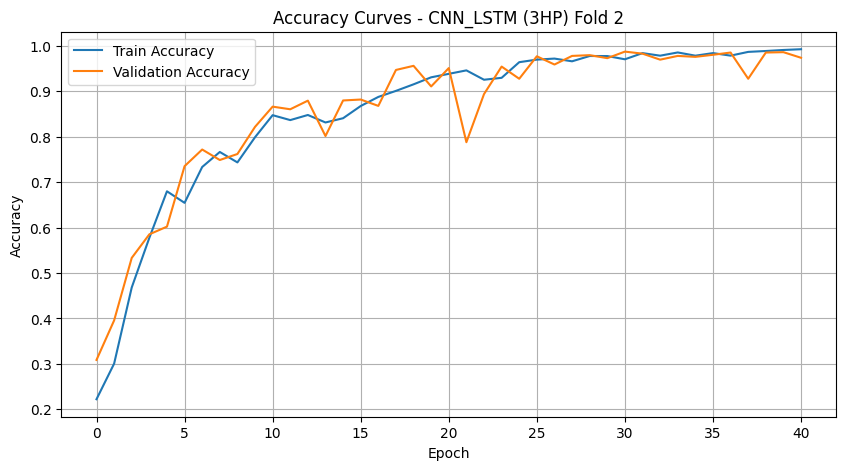

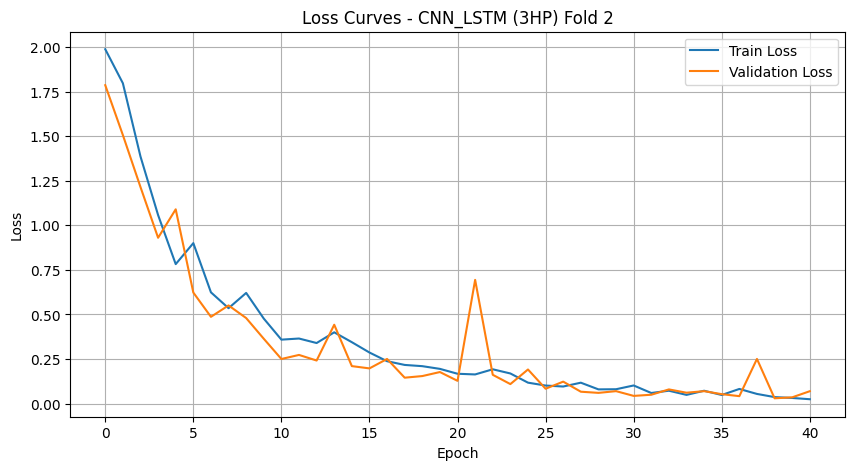


Training Fold 3/5


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 198, 40)   │          0 │ conv1d_38[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 195, 30)   │          0 │ conv1d_36[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_7          │ (None, 195, 30)   │          0 │ max_pooling1d_14… │
│ (Multiply)          │                   │            │ conv1d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 195, 60)   │     21,840 │ multiply_7[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 60)        │     29,040 │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 60)        │          0 │ lstm_15[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 10)        │        610 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


2025-07-10 21:08:43.693192: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 21:08:43.693802: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.2904 - loss: 1.8577

2025-07-10 21:09:36.167350: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 21:09:36.167797: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 56s 173ms/step - accuracy: 0.2907 - loss: 1.8570 - val_accuracy: 0.4067 - val_loss: 1.4423
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.2946 - loss: 2.1806

304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.2948 - loss: 2.1792 - val_accuracy: 0.5414 - val_loss: 1.1322
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.4717 - loss: 1.3828

304/304 ━━━━━━━━━━━━━━━━━━━━ 57s 188ms/step - accuracy: 0.4717 - loss: 1.3828 - val_accuracy: 0.5979 - val_loss: 1.0683
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5645 - loss: 1.0381

304/304 ━━━━━━━━━━━━━━━━━━━━ 55s 182ms/step - accuracy: 0.5646 - loss: 1.0378 - val_accuracy: 0.6930 - val_loss: 0.7721
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.6776 - loss: 0.7694

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.6776 - loss: 0.7693 - val_accuracy: 0.7944 - val_loss: 0.4899
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7416 - loss: 0.6170

304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 176ms/step - accuracy: 0.7416 - loss: 0.6169 - val_accuracy: 0.8121 - val_loss: 0.3945
Epoch 7/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7656 - loss: 0.5627

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.7657 - loss: 0.5626 - val_accuracy: 0.8397 - val_loss: 0.3915
Epoch 8/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 172ms/step - accuracy: 0.7531 - loss: 0.5921 - val_accuracy: 0.8381 - val_loss: 0.3622
Epoch 9/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8458 - loss: 0.3779

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.8458 - loss: 0.3778 - val_accuracy: 0.8669 - val_loss: 0.2557
Epoch 10/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8609 - loss: 0.3042

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.8608 - loss: 0.3044 - val_accuracy: 0.8694 - val_loss: 0.2834
Epoch 11/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8512 - loss: 0.3488

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.8513 - loss: 0.3487 - val_accuracy: 0.8855 - val_loss: 0.2042
Epoch 12/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8589 - loss: 0.3107

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.8589 - loss: 0.3107 - val_accuracy: 0.8908 - val_loss: 0.1855
Epoch 13/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.8839 - loss: 0.2378 - val_accuracy: 0.8883 - val_loss: 0.1904
Epoch 14/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8926 - loss: 0.2140

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.8926 - loss: 0.2140 - val_accuracy: 0.8995 - val_loss: 0.1676
Epoch 15/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8897 - loss: 0.2146

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.8897 - loss: 0.2146 - val_accuracy: 0.9102 - val_loss: 0.1569
Epoch 16/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.9059 - loss: 0.1945 - val_accuracy: 0.8999 - val_loss: 0.1659
Epoch 17/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8969 - loss: 0.2082

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.8969 - loss: 0.2082 - val_accuracy: 0.9353 - val_loss: 0.1562
Epoch 18/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - accuracy: 0.8946 - loss: 0.2534 - val_accuracy: 0.9324 - val_loss: 0.1372
Epoch 19/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9347 - loss: 0.1532 - val_accuracy: 0.8991 - val_loss: 0.1510
Epoch 20/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9172 - loss: 0.1636

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9172 - loss: 0.1636 - val_accuracy: 0.9468 - val_loss: 0.1339
Epoch 21/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.9429 - loss: 0.1368 - val_accuracy: 0.9192 - val_loss: 0.2027
Epoch 22/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9018 - loss: 0.2127

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - accuracy: 0.9018 - loss: 0.2126 - val_accuracy: 0.9827 - val_loss: 0.0647
Epoch 23/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9718 - loss: 0.0887 - val_accuracy: 0.9724 - val_loss: 0.1140
Epoch 24/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9677 - loss: 0.1105

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - accuracy: 0.9678 - loss: 0.1104 - val_accuracy: 0.9860 - val_loss: 0.0489
Epoch 25/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9828 - loss: 0.0609

304/304 ━━━━━━━━━━━━━━━━━━━━ 45s 148ms/step - accuracy: 0.9828 - loss: 0.0609 - val_accuracy: 0.9864 - val_loss: 0.0305
Epoch 26/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9851 - loss: 0.0569

304/304 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - accuracy: 0.9851 - loss: 0.0569 - val_accuracy: 0.9868 - val_loss: 0.0425
Epoch 27/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9776 - loss: 0.0765

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9776 - loss: 0.0764 - val_accuracy: 0.9905 - val_loss: 0.0298
Epoch 28/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.9878 - loss: 0.0437 - val_accuracy: 0.9757 - val_loss: 0.0662
Epoch 29/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - accuracy: 0.9829 - loss: 0.0589 - val_accuracy: 0.9864 - val_loss: 0.0315
Epoch 30/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9928 - loss: 0.0291 - val_accuracy: 0.9658 - val_loss: 0.0878
Epoch 31/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - accuracy: 0.9812 - loss: 0.0622 - val_accuracy: 0.9893 - val_loss: 0.0334
Epoch 32/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9890 - loss: 0.0372 - val_accuracy: 0.9901 - val_loss: 0.0323
Epoch 33/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9966 - loss: 0.0154 - val_accuracy: 0.9889 - val_loss: 0.0321
Epoch 34/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9891 - loss: 0.037

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9901 - loss: 0.0369 - val_accuracy: 0.9918 - val_loss: 0.0259
Epoch 37/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - accuracy: 0.9912 - loss: 0.0260 - val_accuracy: 0.9823 - val_loss: 0.0485
Epoch 38/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - accuracy: 0.9961 - loss: 0.0143 - val_accuracy: 0.9852 - val_loss: 0.0506
Epoch 39/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - accuracy: 0.9909 - loss: 0.0314 - val_accuracy: 0.9835 - val_loss: 0.0614
Epoch 40/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - accuracy: 0.9918 - loss: 0.0269 - val_accuracy: 0.9909 - val_loss: 0.0332
Epoch 41/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - accuracy: 0.9961 - loss: 0.0147 - val_accuracy: 0.9897 - val_loss: 0.0320
Epoch 42/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - accuracy: 0.9961 - loss: 0.0135 - val_accuracy: 0.9889 - val_loss: 0.0492
Epoch 43/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9930 - loss: 0.025

2025-07-10 21:45:01.534523: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 21:45:01.535672: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step
 3/76 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step

2025-07-10 21:45:15.401048: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 21:45:15.401412: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step


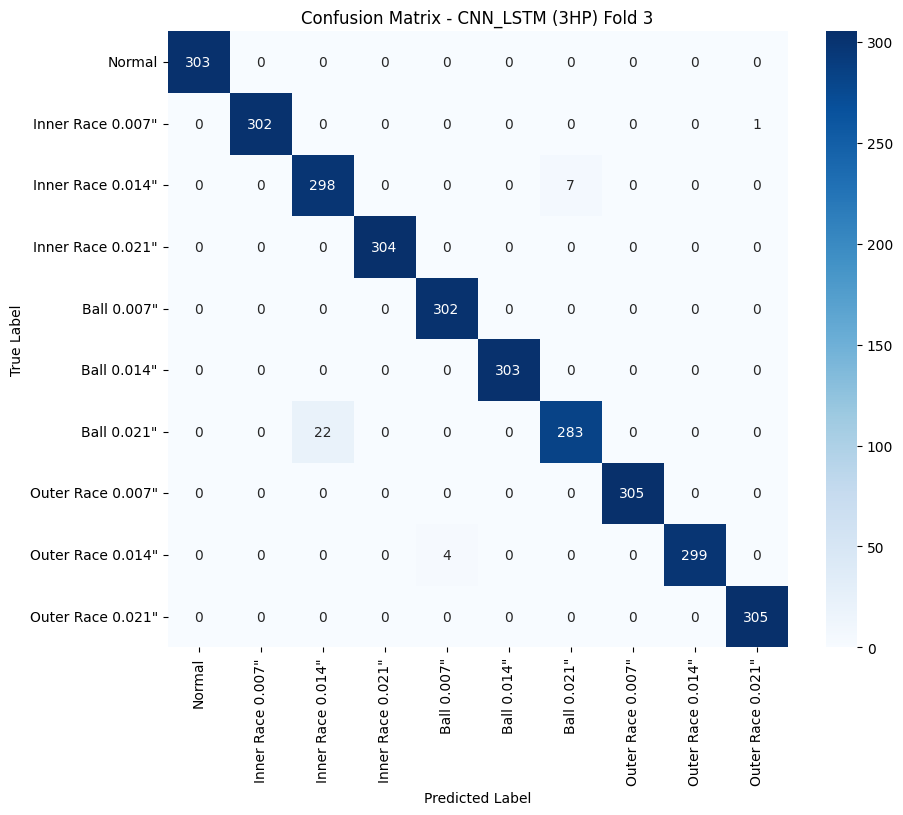

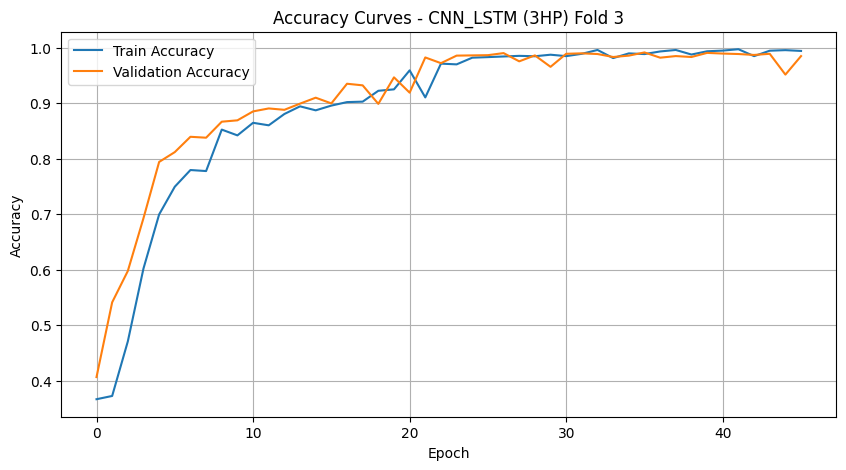

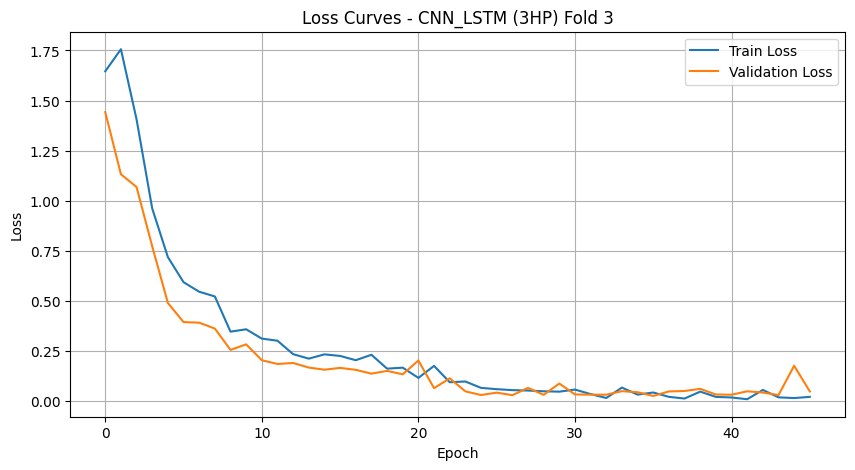


Training Fold 4/5


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_42[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 198, 40)   │          0 │ conv1d_43[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 195, 30)   │          0 │ conv1d_41[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_8          │ (None, 195, 30)   │          0 │ max_pooling1d_16… │
│ (Multiply)          │                   │            │ conv1d_44[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 195, 60)   │     21,840 │ multiply_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 60)        │     29,040 │ lstm_16[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 60)        │          0 │ lstm_17[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10)        │        610 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


2025-07-10 21:45:24.801601: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 21:45:24.802066: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2911 - loss: 1.8586

2025-07-10 21:46:09.577954: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 21:46:09.578371: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 152ms/step - accuracy: 0.2913 - loss: 1.8581 - val_accuracy: 0.2403 - val_loss: 2.0559
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.3346 - loss: 1.7398

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.3349 - loss: 1.7391 - val_accuracy: 0.4674 - val_loss: 1.4094
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5578 - loss: 1.1489

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.5580 - loss: 1.1483 - val_accuracy: 0.7172 - val_loss: 0.6291
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6800 - loss: 0.8174

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.6800 - loss: 0.8173 - val_accuracy: 0.7242 - val_loss: 0.6610
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7335 - loss: 0.6431

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.7336 - loss: 0.6429 - val_accuracy: 0.7514 - val_loss: 0.5383
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7903 - loss: 0.5183

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.7904 - loss: 0.5181 - val_accuracy: 0.8087 - val_loss: 0.3939
Epoch 7/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7850 - loss: 0.4857

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.7850 - loss: 0.4856 - val_accuracy: 0.8615 - val_loss: 0.2720
Epoch 8/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8314 - loss: 0.3872

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.8314 - loss: 0.3872 - val_accuracy: 0.8664 - val_loss: 0.2711
Epoch 9/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.8713 - loss: 0.2780 - val_accuracy: 0.8240 - val_loss: 0.4614
Epoch 10/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8333 - loss: 0.3948

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.8334 - loss: 0.3947 - val_accuracy: 0.8817 - val_loss: 0.2336
Epoch 11/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8610 - loss: 0.3142

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.8610 - loss: 0.3141 - val_accuracy: 0.8912 - val_loss: 0.2104
Epoch 12/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.8825 - loss: 0.2479 - val_accuracy: 0.8854 - val_loss: 0.2519
Epoch 13/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8940 - loss: 0.2571

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.8940 - loss: 0.2571 - val_accuracy: 0.9015 - val_loss: 0.2749
Epoch 14/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9188 - loss: 0.2115

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9188 - loss: 0.2115 - val_accuracy: 0.9225 - val_loss: 0.1745
Epoch 15/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8960 - loss: 0.2425

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - accuracy: 0.8960 - loss: 0.2425 - val_accuracy: 0.9365 - val_loss: 0.2055
Epoch 16/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9263 - loss: 0.2091

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - accuracy: 0.9264 - loss: 0.2090 - val_accuracy: 0.9691 - val_loss: 0.0916
Epoch 17/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9413 - loss: 0.1643 - val_accuracy: 0.9683 - val_loss: 0.0857
Epoch 18/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9633 - loss: 0.1290 - val_accuracy: 0.9431 - val_loss: 0.1667
Epoch 19/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - accuracy: 0.9365 - loss: 0.2012 - val_accuracy: 0.9452 - val_loss: 0.1384
Epoch 20/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9526 - loss: 0.1430 - val_accuracy: 0.9683 - val_loss: 0.0858
Epoch 21/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9632 - loss: 0.1169

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9632 - loss: 0.1168 - val_accuracy: 0.9749 - val_loss: 0.0719
Epoch 22/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9747 - loss: 0.0871 - val_accuracy: 0.9489 - val_loss: 0.1656
Epoch 23/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - accuracy: 0.9748 - loss: 0.0926 - val_accuracy: 0.9654 - val_loss: 0.1093
Epoch 24/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9581 - loss: 0.1459 - val_accuracy: 0.9584 - val_loss: 0.1184
Epoch 25/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9591 - loss: 0.1332 - val_accuracy: 0.9666 - val_loss: 0.0950
Epoch 26/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9821 - loss: 0.0770

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9821 - loss: 0.0770 - val_accuracy: 0.9806 - val_loss: 0.0556
Epoch 27/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9849 - loss: 0.0590 - val_accuracy: 0.9678 - val_loss: 0.0811
Epoch 28/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9835 - loss: 0.0634 - val_accuracy: 0.9769 - val_loss: 0.0678
Epoch 29/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9847 - loss: 0.0525

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9847 - loss: 0.0525 - val_accuracy: 0.9819 - val_loss: 0.0509
Epoch 30/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9627 - loss: 0.1561 - val_accuracy: 0.9761 - val_loss: 0.0639
Epoch 31/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9794 - loss: 0.0751 - val_accuracy: 0.9571 - val_loss: 0.1218
Epoch 32/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9717 - loss: 0.1035 - val_accuracy: 0.9790 - val_loss: 0.0600
Epoch 33/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9826 - loss: 0.0668 - val_accuracy: 0.9790 - val_loss: 0.0588
Epoch 34/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9909 - loss: 0.0430 - val_accuracy: 0.9786 - val_loss: 0.0600
Epoch 35/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9906 - loss: 0.0391 - val_accuracy: 0.9782 - val_loss: 0.0710
Epoch 36/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9865 - loss: 0.044

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9903 - loss: 0.0379 - val_accuracy: 0.9868 - val_loss: 0.0378
Epoch 38/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9832 - loss: 0.0589 - val_accuracy: 0.9819 - val_loss: 0.0442
Epoch 39/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9901 - loss: 0.0357

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9901 - loss: 0.0357 - val_accuracy: 0.9872 - val_loss: 0.0318
Epoch 40/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9945 - loss: 0.0240 - val_accuracy: 0.9860 - val_loss: 0.0403
Epoch 41/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9928 - loss: 0.0247

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9928 - loss: 0.0247 - val_accuracy: 0.9876 - val_loss: 0.0345
Epoch 42/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9930 - loss: 0.0226 - val_accuracy: 0.9732 - val_loss: 0.1050
Epoch 43/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.9889 - loss: 0.0398 - val_accuracy: 0.9815 - val_loss: 0.0572
Epoch 44/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9958 - loss: 0.0214 - val_accuracy: 0.9596 - val_loss: 0.1364
Epoch 45/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - accuracy: 0.9711 - loss: 0.1102 - val_accuracy: 0.9769 - val_loss: 0.0678
Epoch 46/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9799 - loss: 0.0675 - val_accuracy: 0.9810 - val_loss: 0.0633
Epoch 47/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9922 - loss: 0.0273 - val_accuracy: 0.9843 - val_loss: 0.0555
Epoch 48/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9908 - loss: 0.042

2025-07-10 22:23:53.875288: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 22:23:53.876214: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step
 3/76 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step

2025-07-10 22:24:07.298317: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 22:24:07.298671: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step


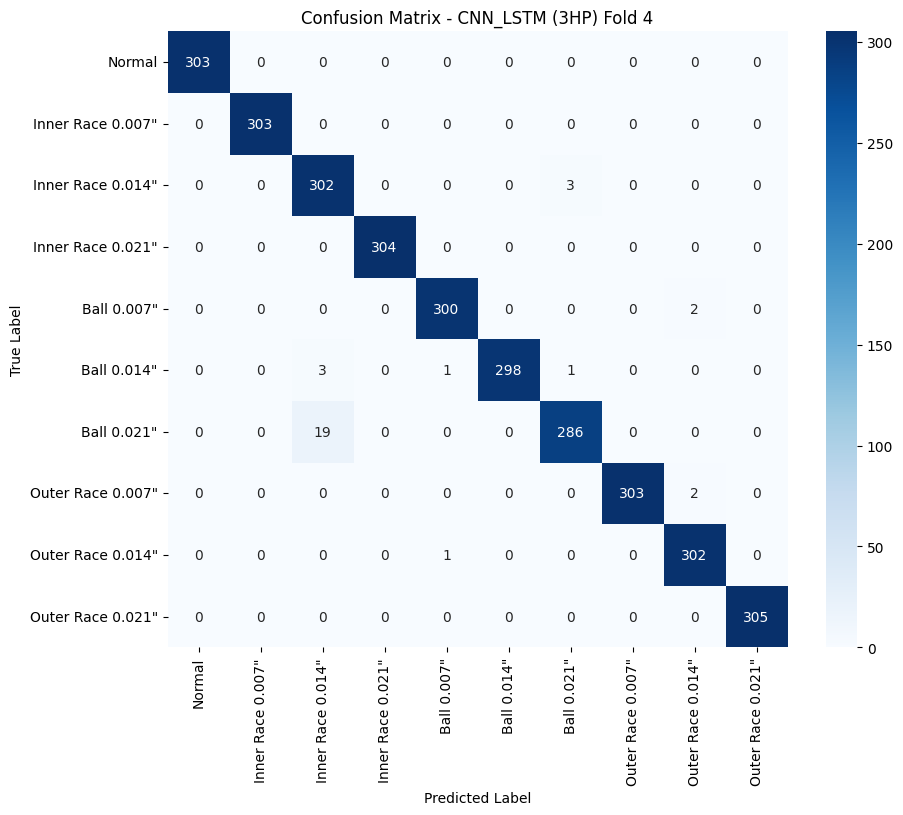

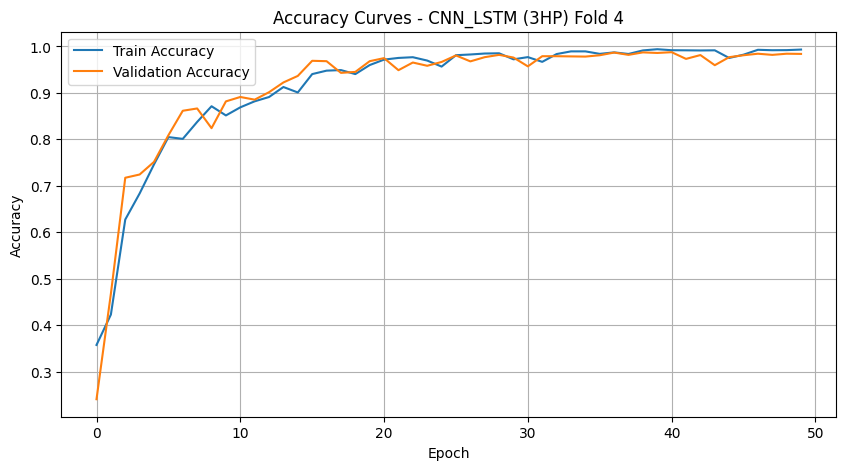

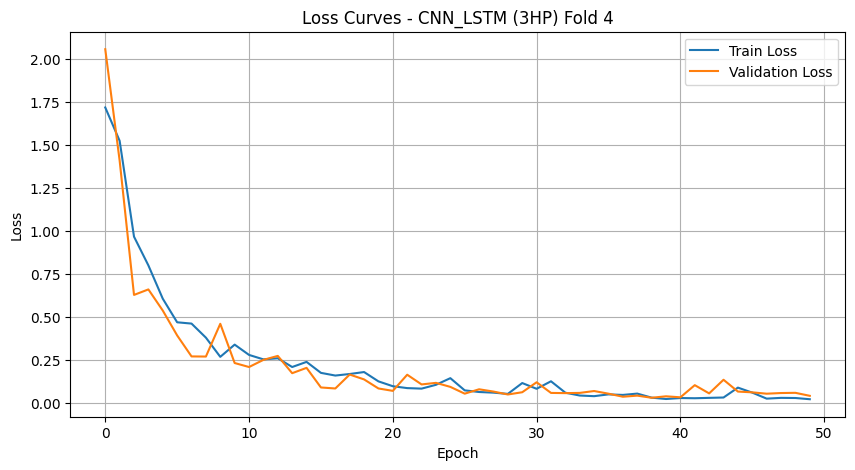


Training Fold 5/5


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_48 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_47[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 198, 40)   │          0 │ conv1d_48[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 195, 30)   │          0 │ conv1d_46[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 195, 30)   │          0 │ max_pooling1d_18… │
│ (Multiply)          │                   │            │ conv1d_49[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 195, 60)   │     21,840 │ multiply_9[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 60)        │     29,040 │ lstm_18[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 60)        │          0 │ lstm_19[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 10)        │        610 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


2025-07-10 22:24:16.593801: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 22:24:16.594182: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.2516 - loss: 1.9028

2025-07-10 22:25:01.837798: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-07-10 22:25:01.838137: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 153ms/step - accuracy: 0.2518 - loss: 1.9022 - val_accuracy: 0.3557 - val_loss: 1.8142
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4239 - loss: 1.4888

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.4240 - loss: 1.4884 - val_accuracy: 0.5548 - val_loss: 1.2201
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 159ms/step - accuracy: 0.5240 - loss: 1.2304 - val_accuracy: 0.4242 - val_loss: 1.4794
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4641 - loss: 1.3667

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.4643 - loss: 1.3663 - val_accuracy: 0.5948 - val_loss: 1.0139
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5770 - loss: 1.0634

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.5771 - loss: 1.0633 - val_accuracy: 0.6674 - val_loss: 0.7818
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6545 - loss: 0.8411

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.6545 - loss: 0.8411 - val_accuracy: 0.6838 - val_loss: 0.7361
Epoch 7/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7095 - loss: 0.7108

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.7096 - loss: 0.7107 - val_accuracy: 0.7692 - val_loss: 0.5516
Epoch 8/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7605 - loss: 0.5955

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.7605 - loss: 0.5955 - val_accuracy: 0.8017 - val_loss: 0.4622
Epoch 9/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.7446 - loss: 0.6492 - val_accuracy: 0.7716 - val_loss: 0.5487
Epoch 10/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7971 - loss: 0.4955

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.7971 - loss: 0.4954 - val_accuracy: 0.8075 - val_loss: 0.4263
Epoch 11/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8004 - loss: 0.4654

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.8005 - loss: 0.4653 - val_accuracy: 0.8261 - val_loss: 0.3596
Epoch 12/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7489 - loss: 0.6928

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.7491 - loss: 0.6923 - val_accuracy: 0.8644 - val_loss: 0.2985
Epoch 13/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8544 - loss: 0.3376

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.8544 - loss: 0.3376 - val_accuracy: 0.8821 - val_loss: 0.2796
Epoch 14/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8693 - loss: 0.3039

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.8693 - loss: 0.3039 - val_accuracy: 0.8871 - val_loss: 0.2276
Epoch 15/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.8732 - loss: 0.2765 - val_accuracy: 0.8846 - val_loss: 0.2402
Epoch 16/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8872 - loss: 0.2523

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.8872 - loss: 0.2525 - val_accuracy: 0.9073 - val_loss: 0.2169
Epoch 17/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8912 - loss: 0.2569

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.8912 - loss: 0.2568 - val_accuracy: 0.9378 - val_loss: 0.1599
Epoch 18/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9086 - loss: 0.2166 - val_accuracy: 0.9287 - val_loss: 0.1632
Epoch 19/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9241 - loss: 0.2009

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9241 - loss: 0.2009 - val_accuracy: 0.9753 - val_loss: 0.0833
Epoch 20/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9382 - loss: 0.1702 - val_accuracy: 0.9423 - val_loss: 0.1403
Epoch 21/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.9193 - loss: 0.2325 - val_accuracy: 0.9707 - val_loss: 0.0863
Epoch 22/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9395 - loss: 0.1723

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9395 - loss: 0.1723 - val_accuracy: 0.9823 - val_loss: 0.0667
Epoch 23/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9479 - loss: 0.1566 - val_accuracy: 0.9732 - val_loss: 0.0837
Epoch 24/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.9552 - loss: 0.1357 - val_accuracy: 0.9340 - val_loss: 0.1884
Epoch 25/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9499 - loss: 0.1658 - val_accuracy: 0.9765 - val_loss: 0.0842
Epoch 26/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9734 - loss: 0.0990

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9734 - loss: 0.0989 - val_accuracy: 0.9839 - val_loss: 0.0633
Epoch 27/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9454 - loss: 0.1727 - val_accuracy: 0.9134 - val_loss: 0.2281
Epoch 28/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.9130 - loss: 0.2500 - val_accuracy: 0.9806 - val_loss: 0.0684
Epoch 29/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 57s 188ms/step - accuracy: 0.9676 - loss: 0.1095 - val_accuracy: 0.9839 - val_loss: 0.0532
Epoch 30/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 54s 175ms/step - accuracy: 0.9792 - loss: 0.0875 - val_accuracy: 0.9815 - val_loss: 0.0565
Epoch 31/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9697 - loss: 0.1081

304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - accuracy: 0.9697 - loss: 0.1080 - val_accuracy: 0.9893 - val_loss: 0.0352
Epoch 32/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 174ms/step - accuracy: 0.9847 - loss: 0.0575 - val_accuracy: 0.9806 - val_loss: 0.0609
Epoch 33/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 54s 178ms/step - accuracy: 0.9747 - loss: 0.0866 - val_accuracy: 0.9823 - val_loss: 0.0608
Epoch 34/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 175ms/step - accuracy: 0.9546 - loss: 0.1689 - val_accuracy: 0.9724 - val_loss: 0.0939
Epoch 35/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.9735 - loss: 0.0899 - val_accuracy: 0.9889 - val_loss: 0.0331
Epoch 36/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9817 - loss: 0.0630

304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9817 - loss: 0.0630 - val_accuracy: 0.9913 - val_loss: 0.0271
Epoch 37/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9833 - loss: 0.0624 - val_accuracy: 0.9897 - val_loss: 0.0301
Epoch 38/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.9798 - loss: 0.0681 - val_accuracy: 0.9913 - val_loss: 0.0346
Epoch 39/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9823 - loss: 0.0624 - val_accuracy: 0.9835 - val_loss: 0.0410
Epoch 40/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9844 - loss: 0.0589

304/304 ━━━━━━━━━━━━━━━━━━━━ 55s 182ms/step - accuracy: 0.9844 - loss: 0.0588 - val_accuracy: 0.9951 - val_loss: 0.0165
Epoch 41/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 174ms/step - accuracy: 0.9757 - loss: 0.0906 - val_accuracy: 0.9901 - val_loss: 0.0281
Epoch 42/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9863 - loss: 0.0466 - val_accuracy: 0.9934 - val_loss: 0.0217
Epoch 43/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - accuracy: 0.9919 - loss: 0.0319 - val_accuracy: 0.9909 - val_loss: 0.0297
Epoch 44/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9856 - loss: 0.0500 - val_accuracy: 0.9930 - val_loss: 0.0209
Epoch 45/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9815 - loss: 0.0641 - val_accuracy: 0.9905 - val_loss: 0.0283
Epoch 46/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 54s 178ms/step - accuracy: 0.9935 - loss: 0.0233 - val_accuracy: 0.9909 - val_loss: 0.0256
Epoch 47/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 57s 187ms/step - accuracy: 0.9878 - loss: 0.044

2025-07-10 23:05:01.027052: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 23:05:01.031696: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step
 3/76 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step

2025-07-10 23:05:23.542267: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 23:05:23.542789: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step


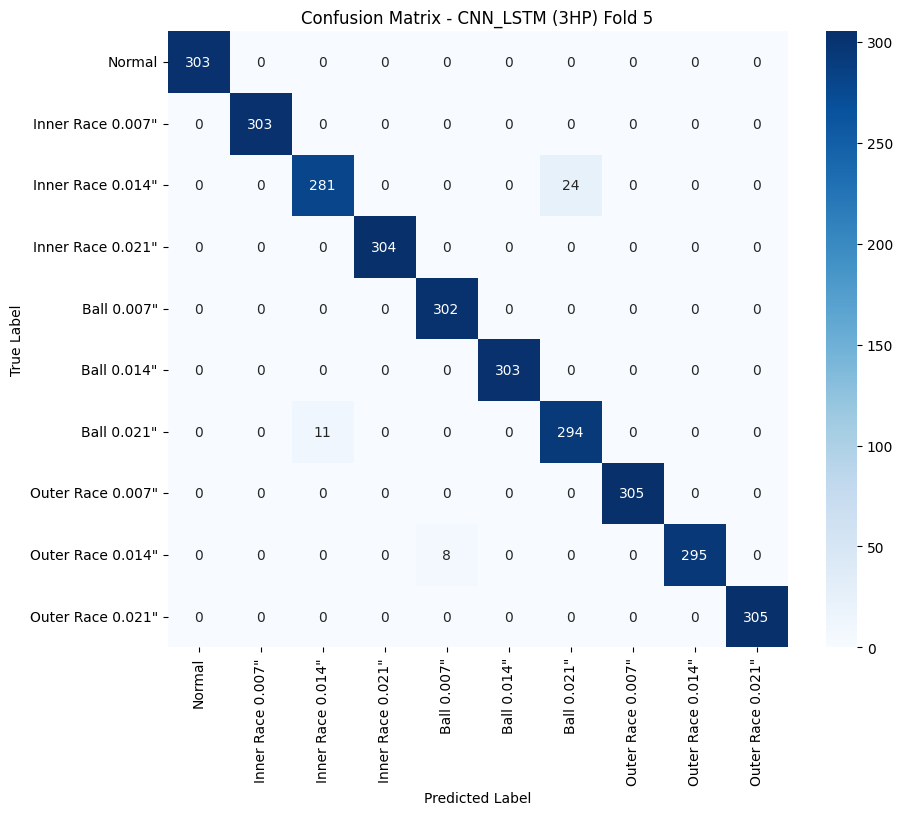

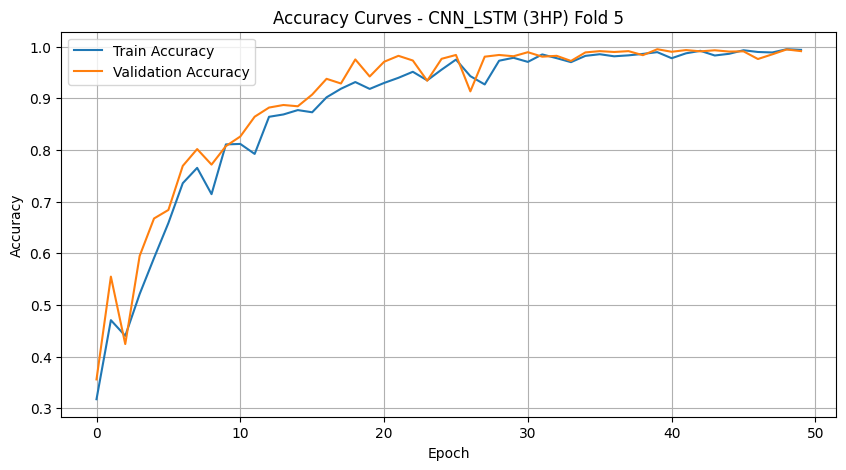

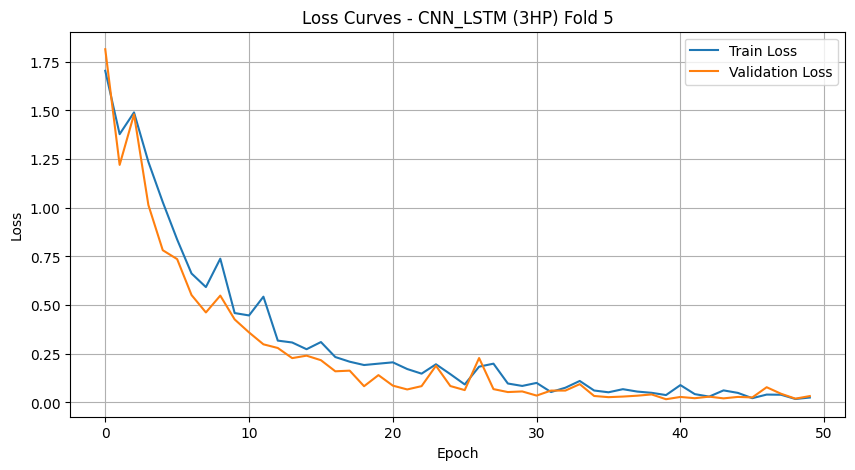

In [9]:
# Define class names
class_names = [
    'Normal', 'Inner Race 0.007"', 'Inner Race 0.014"', 'Inner Race 0.021"',
    'Ball 0.007"', 'Ball 0.014"', 'Ball 0.021"',
    'Outer Race 0.007"', 'Outer Race 0.014"', 'Outer Race 0.021"'
]

# Run experiments
print("Running 2HP CNN-LSTM Experiment")
metrics_2hp_cnn_lstm = run_experiment(
    X_train_2HP_CNN_LSTM, y_train_2HP_CNN_LSTM, X_test_2HP_CNN_LSTM, y_test_2HP_CNN_LSTM,
    CNN_LSTM_Model, kfold, "CNN_LSTM", "2HP", class_names
)

print("\nRunning 3HP CNN-LSTM Experiment")
metrics_3hp_cnn_lstm = run_experiment(
    X_train_3HP_CNN_LSTM, y_train_3HP_CNN_LSTM, X_test_3HP_CNN_LSTM, y_test_3HP_CNN_LSTM,
    CNN_LSTM_Model, kfold, "CNN_LSTM", "3HP", class_names
)

### Results Summary

In [ ]:
import glob
import pandas as pd
def load_latest_metrics(metrics_dir, filename_pattern):
    """Load the latest JSON file matching the pattern in the given directory."""
    files = glob.glob(os.path.join(metrics_dir, f"{filename_pattern}*.json"))
    if not files:
        print(f"No files found in {metrics_dir} for pattern {filename_pattern}")
        return None
    latest_file = max(files, key=os.path.getctime)
    try:
        with open(latest_file, 'r') as file:
            return json.load(file)
    except Exception as e:
        print(f"Error loading {latest_file}: {e}")
        return None

# Load average metrics for LSTM experiments
''' The following code loads the average metrics for the CNN_LSTM model with different hyperparameters 
(2HP and 3HP) from the specified directory. It then creates a summary DataFrame and prints it.
Additionally, it loads and displays the per-class classification report for CNN_LSTM (2HP, Fold 1)
and aggregates per-class metrics across folds for CNN_LSTM (2HP).'''


experiments = [
    ("CNN_LSTM", "2HP", "average_metrics_fold0"),
    ("CNN_LSTM", "3HP", "average_metrics_fold0")
]

summary_data = []
for model_type, hp, pattern in experiments:
    metrics_dir = os.path.join("LSTM_results_for_report", "Metrics", model_type, hp)
    data = load_latest_metrics(metrics_dir, pattern)
    if data:
        df = pd.DataFrame(data, index=[0])
        print(f"\nAverage Metrics for {model_type} ({hp}):")
        print(df)
        summary_data.append({
            'Model': f"{model_type} ({hp})",
            'Avg Train Accuracy': data['avg_train_accuracy'],
            'Avg Val Accuracy': data['avg_val_accuracy'],
            'Avg Test Accuracy': data['avg_test_accuracy']
        })

# Summary table
summary_df = pd.DataFrame(summary_data)
print("\nSummary of Average Metrics Across Experiments:")
print(summary_df)

# Load and display per-class classification report for LSTM (2HP, Fold 1)
metrics_dir = os.path.join("LSTM_results_for_report", "Metrics", "CNN_LSTM", "2HP")
data = load_latest_metrics(metrics_dir, "metrics_fold1")
if data:
    print("\nPer-Class Classification Report (LSTM, 2HP, Fold 1):")
    print(f"Fold: {data['fold']}")
    print(f"Train Accuracy: {data['train_accuracy']:.4f}")
    print(f"Validation Accuracy: {data['val_accuracy']:.4f}")
    print(f"Test Accuracy: {data['test_accuracy']:.4f}")
    report = data["classification_report"]
    class_report = {k: v for k, v in report.items() if isinstance(v, dict)}
    df_report = pd.DataFrame(class_report).T
    print("\nPer-Class Metrics:")
    print(df_report)

# Aggregate per-class metrics across folds for LSTM (2HP)
fold_files = glob.glob(os.path.join(metrics_dir, "metrics_fold*.json"))
class_metrics = []
for fold_file in fold_files:
    with open(fold_file, 'r') as f:
        data = json.load(f)
        report = data['classification_report']
        for cls in class_names:
            class_metrics.append({
                'Fold': data['fold'],
                'Class': cls,
                'Precision': report[cls]['precision'],
                'Recall': report[cls]['recall'],
                'F1-Score': report[cls]['f1-score']
            })

class_df = pd.DataFrame(class_metrics)
avg_class_metrics = class_df.groupby('Class').mean().reset_index()
print("\nAverage Per-Class Metrics for LSTM (2HP):")
print(avg_class_metrics[['Class', 'Precision', 'Recall', 'F1-Score']])


Average Metrics for CNN_LSTM (2HP):
   avg_train_accuracy  avg_val_accuracy  avg_test_accuracy
0            0.997754          0.992335           0.991107

Average Metrics for CNN_LSTM (3HP):
   avg_train_accuracy  avg_val_accuracy  avg_test_accuracy
0            0.994148          0.982611           0.987953

Summary of Average Metrics Across Experiments:
            Model  Avg Train Accuracy  Avg Val Accuracy  Avg Test Accuracy
0  CNN_LSTM (2HP)            0.997754          0.992335           0.991107
1  CNN_LSTM (3HP)            0.994148          0.982611           0.987953

Per-Class Classification Report (LSTM, 2HP, Fold 1):
Fold: 1
Train Accuracy: 0.9982
Validation Accuracy: 0.9901
Test Accuracy: 0.9908

Per-Class Metrics:
                   precision    recall  f1-score  support
Normal              1.000000  1.000000  1.000000    302.0
Inner Race 0.007"   1.000000  1.000000  1.000000    303.0
Inner Race 0.014"   0.957096  0.957096  0.957096    303.0
Inner Race 0.021"   1.000000  

/var/folders/px/h6cz0_fx3pz2knsspxg_65kc0000gn/T/ipykernel_63336/99762762.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Avg Test Accuracy', data=summary_df, palette=['#36A2EB', '#FF6384'])


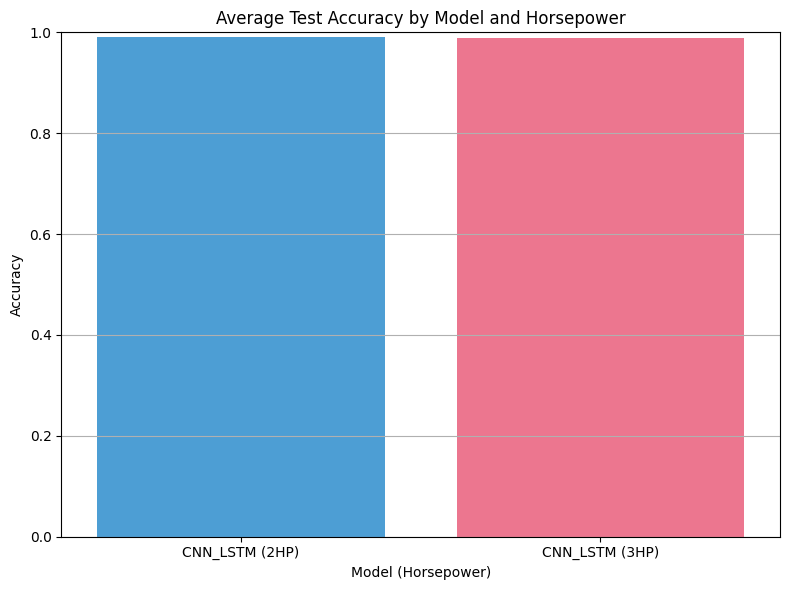

In [14]:
# Bar plot for average test accuracies using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming summary_df is available from the previous code
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Avg Test Accuracy', data=summary_df, palette=['#36A2EB', '#FF6384'])
plt.title('Average Test Accuracy by Model and Horsepower')
plt.xlabel('Model (Horsepower)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis to start at 0, like the Chart.js version
plt.grid(True, axis='y')
plt.tight_layout()

# Save the plot for the report
plt.savefig('LSTM_results_for_report/Plots/avg_test_accuracy_barplot.png', dpi=300, bbox_inches='tight')
plt.show()